<img src = "../../Data/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bpi}{\boldsymbol \pi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bS}{\boldsymbol{\Sigma}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\hy}{\hat{y}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Project: Linear Classification

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Data preparation
+ Logistic Regression Models(s) have been used
+ Cover Type prediction made
+ Accuracy of predictions for test set (kaggle)
+ Class imbalance management
+ Hyperparameter optimization

# General

### Imports

In [2]:
#we import all at the beginning so it's easier to see which packages are used by this notebook

#importing relevant packages
import pandas as pd
%matplotlib inline
# This is a Python module that contains plotting commands
import matplotlib.pyplot as plt
# the following provides further tools for plotting with dfs
import seaborn as sns 
from scipy.stats import skew 
from sklearn.metrics import confusion_matrix
import numpy as np

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import plot_confusion_matrix, get_auc

#import packages related to model fitting
from sklearn.linear_model import LogisticRegression

#import package to save models
import joblib

#import packages related to evaluating our models' accuracy/performance
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.model_selection import cross_val_score as cvs

#importing packages that we will use in our randomized grid search
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#import packages relevant to preprocessing
from sklearn import preprocessing
from project2_functions.my_preprocessor import my_scaler

#import packages relevant to feature transformations
from sklearn.preprocessing import PolynomialFeatures as plf
from project2_functions.my_transformation import my_dummy, my_total_transformer_bi

#import packages relevant to plotting
from project2_functions.my_plot import my_count_plot, my_dist_plot, my_coef_plot, my_plot_size_default, my_coef_plot_multi

#importing packages related to reweighting of probabilities
from project2_functions.my_reweight import reweight

#hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#packages to tackle class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter

### Step 1: Read and explore data

In [3]:
#we read the train data
train = pd.read_csv("G:/My Drive/project2/bgse-lc-forest/forest-cover-classification/MultiClass_Train.csv")
train_orig = train.copy()

#we also read the test data now so we could use it for the data transformations
test = pd.read_csv("G:/My Drive/project2/bgse-lc-forest/forest-cover-classification/MultiClass_Test.csv")
test_orig = test.copy()

In [4]:
train.head()

,Index,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,4,3048,333,11,124,31,2823,196,226,170,666,1,1,23


In [5]:
train.shape

(61006, 14)

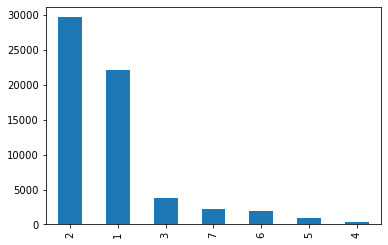

In [6]:
# clearly, there the class imbalance in our dataset is severe
my_count_plot(train, 'Cover_Type')

In [7]:
train = train.drop(['Index'], axis = 1)
test = test.drop(['Index'], axis = 1)

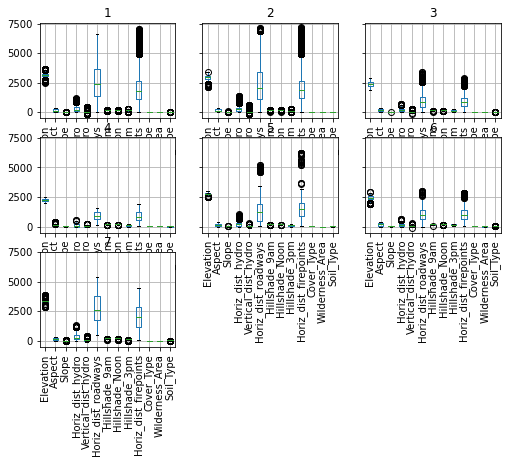

In [8]:
plt.rcParams["figure.figsize"] = (8,6)
my_dist_plot(train, 'Cover_Type') 
#note that we cannot say much about the distribution since the variables are not scaled yet
# therefore it's difficult to see the distribution since those with larger magnitudes overshadow those
#with lower ones

# Binary classification

### Step 2: Create dummies for relevant features

Only the variables Wilderness_Area and Soil_Type are categories. Therefore, we transform these to dummies.

Note that I choose not do **polynomial transformations yet** (at least for this part) as I see no reason to do this given the variables I have. But perhaps this might be useful later on since there might be some quadaratic relationship between the labels and some features, as well as some interactions between features. **I will do polynomial transformations togethering with filtering to limit the number of dummy variables in the latter part of the notebook.**

In [9]:
cols=['Wilderness_Area', 'Soil_Type']
X_train, X_test = my_dummy(train, test, cols)

In [10]:
X_train.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,3202,34,10,0,0,2760,219,218,134,1734,...,0,0,0,0,0,0,0,1,0,0
1,3113,251,13,192,40,5600,191,249,195,2555,...,0,0,0,0,0,0,0,0,0,0
2,2801,77,9,510,17,1728,232,223,122,1087,...,0,0,0,0,0,0,0,0,0,0
3,3165,82,9,319,56,4890,233,225,124,1452,...,0,0,0,0,0,0,0,0,0,0
4,3048,333,11,124,31,2823,196,226,170,666,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X_test.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,3111,72,13,283,76,630,235,214,109,499,...,1,0,0,0,0,0,0,0,0,0
1,2768,0,20,134,26,912,186,198,146,1974,...,0,0,0,0,0,0,0,0,0,0
2,3360,272,13,685,178,4502,185,244,198,2642,...,0,0,0,0,0,0,0,0,1,0
3,2413,0,3,201,18,560,215,233,156,866,...,0,0,0,0,0,0,0,0,0,0
4,2815,54,11,42,9,2313,226,217,123,2866,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#the difference in the number of columns of the train and test data is the column "Cover_Type"

In [13]:
y =  X_train['Cover_Type'] #storing labels

In [14]:
X_train = X_train.drop(['Cover_Type'], axis = 1) # we remove from the X_train the labels

In [15]:
X_train.shape

(61006, 51)

In [16]:
X_train.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,3202,34,10,0,0,2760,219,218,134,1734,...,0,0,0,0,0,0,0,1,0,0
1,3113,251,13,192,40,5600,191,249,195,2555,...,0,0,0,0,0,0,0,0,0,0
2,2801,77,9,510,17,1728,232,223,122,1087,...,0,0,0,0,0,0,0,0,0,0
3,3165,82,9,319,56,4890,233,225,124,1452,...,0,0,0,0,0,0,0,0,0,0
4,3048,333,11,124,31,2823,196,226,170,666,...,0,0,0,0,0,0,0,0,0,0


### Standardization/scaling

In [17]:
X_train, X_test = my_scaler(X_train, X_test) #using my custom function

In [18]:
X_train.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.869608,-1.089548,-0.549948,-1.267979,-0.798254,0.262324,0.262693,-0.259695,-0.224995,-0.186425,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,6.048836,-0.157516,-0.121675
1,0.552827,0.844259,-0.152141,-0.362494,-0.113321,2.082645,-0.773196,1.297340,1.364189,0.436970,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
2,-0.557684,-0.706351,-0.682551,1.137217,-0.507158,-0.399145,0.743641,-0.008560,-0.537621,-0.677700,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
3,0.737912,-0.661793,-0.682551,0.236447,0.160652,1.627565,0.780637,0.091894,-0.485516,-0.400551,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
4,0.321471,1.575006,-0.417346,-0.683187,-0.267431,0.302704,-0.588216,0.142121,0.712884,-0.997370,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675


In [19]:
X_train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area_2', 'Wilderness_Area_3', 'Wilderness_Area_4',
       'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5',
       'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9',
       'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13',
       'Soil_Type_14', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18',
       'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22',
       'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26',
       'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30',
       'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34',
       'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38',
       'Soil_Type_39', 'Soil_Type_40'],
      dtype='object')

In [20]:
X_test.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.542354,-0.755712,-0.155142,0.078855,0.505860,-1.106881,0.852761,-0.468094,-0.872820,-1.111472,...,4.776231,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441
1,-0.687794,-1.396990,0.777410,-0.629645,-0.341629,-0.925999,-0.960632,-1.278194,0.086613,-0.014140,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441
2,1.435377,1.025613,-0.155142,1.990379,2.234739,1.376711,-0.997640,1.050843,1.435005,0.482821,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,6.405886,-0.114441
3,-1.960980,-1.396990,-1.487359,-0.311058,-0.477227,-1.151780,0.112601,0.493900,0.345919,-0.838441,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441
4,-0.519232,-0.916032,-0.421585,-1.067108,-0.629775,-0.027365,0.519689,-0.316200,-0.509792,0.649467,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441


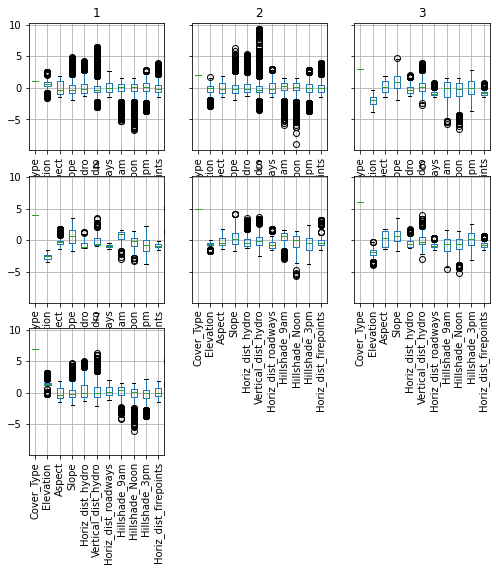

In [21]:
check_dist_df = X_train[['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints']]
check_dist_df = pd.concat([y, check_dist_df], axis=1)

my_dist_plot(check_dist_df, 'Cover_Type')
#we observe that Classes 2 and 1 have more distributed data, especiall for the feature 'Vertical_dist_hydro'
#this is as expected since there are so much more observations in classes 2 and 1, making them likely more varied

## Binary (Unbalanced)

### Step 3: Reformat the data to have an binary class target 

In [22]:
#class #7 is the target to predict
X_train_bi = X_train #we store the train data to another object just so we don't overwrite the original one

X_train_bi['Cover_Type'] = [1 if q >= 7 else 0 for q in train.Cover_Type ] 
#we transform the Cover_Type from the train dataset to binary, and add this to to the dataframe X_train_bi

In [23]:
#preparing the data
y_bi = X_train_bi["Cover_Type"] #storing labels
X_train_bi = X_train_bi.drop('Cover_Type', axis =1) #storing features
data_bi = pd.concat([X_train_bi, y_bi], axis=1) #we combine them for the plot that shows variance in the features per class

In [24]:
y_bi.dtypes

dtype('int64')

0    58843
1     2163
Name: Cover_Type, dtype: int64

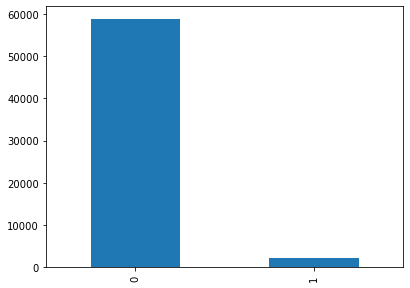

In [25]:
my_plot_size_default()

y_bi.value_counts().plot(kind="bar")
#we observe that there is a class imbalance for our data is severe
#but this is expected since we have combined the other 6 types, with cover types 2 and 1 having more than
#20,000 observations each

y_bi.value_counts() #we observe that most observations are not class 7

In [26]:
bi_cols = data_bi.columns
print(bi_cols)

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area_2', 'Wilderness_Area_3', 'Wilderness_Area_4',
       'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5',
       'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9',
       'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13',
       'Soil_Type_14', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18',
       'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22',
       'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26',
       'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30',
       'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34',
       'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38',
       'Soil_Type_39', 'Soil_Type_40', 'Cover_Type'],
      dtype='object')


In [27]:
bi_box = X_train[['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints', 'Cover_Type']]

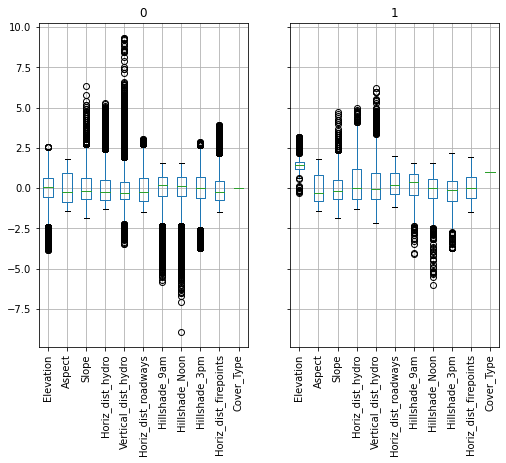

In [28]:
plt.rcParams["figure.figsize"] = (8,6)
my_dist_plot(bi_box,"Cover_Type")

#now we could observe that the values of features in the "Not Class 7" are more varied that those of in Class 7
# this is understandable since we have lumped togeher 6 different cover types to not Class 7.

### Step 4: Build a binary model to predict class #7

In [29]:
feature_names = X_train_bi.columns #storing feature names
class_labels_bi = ["Not Class 7","Class 7"] # meant to represent 0 and 1

In [30]:
#importing LogisticRegression 
#from sklearn.linear_model import LogisticRegression
# we have already imported all relevant libraries at the beginning so it is
#easier to track which packages are already imported/loaded

#specifying parameters/specificiations of our logistic regression)
lregr = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

#fitting our first binary model
#note that this model does not correct for class imbalance
lregr.fit(X_train_bi,y_bi)     

LogisticRegression(C=100.0, max_iter=500, solver='liblinear')

In [31]:
#joblib so for us not to load the data again

#save model using joblib
filename = 'lregr.sav'
joblib.dump(lregr, filename)

# load the model from disk
joblib_lregr = joblib.load(filename)

In [32]:
#we produce in-sample predictions
insample_labels = joblib_lregr.predict(X_train_bi)
print(insample_labels)

[0 0 0 ... 0 0 0]


In [33]:
#we store the probabilities of being 
insample_pred = lregr.predict_proba(X_train_bi)
insample_pred 
# first column, prob of not class 7 (encoded as 0), 
#second column prob of being class 7 (encoded as 1)

array([[5.19796206e-01, 4.80203794e-01],
       [9.99828793e-01, 1.71206698e-04],
       [9.99999858e-01, 1.42411725e-07],
       ...,
       [9.98308938e-01, 1.69106194e-03],
       [9.99994740e-01, 5.26029052e-06],
       [9.99999455e-01, 5.45208656e-07]])

[[58418   425]
 [  942  1221]]


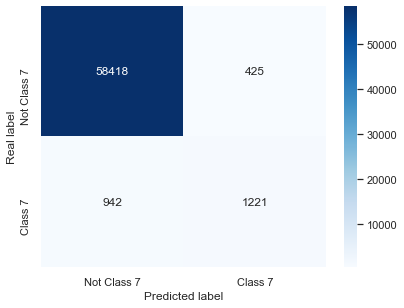

In [34]:
#confusion matrix of in-sample predictions

#we plot predicted labels against real labels
cm =  confusion_matrix(y_pred=insample_labels, y_true=y_bi, labels=[0,1])
print (cm)
# Plotting confusion matrix (custom help function)
my_plot_size_default()
plot_confusion_matrix(cm, class_labels_bi) ## From the utils folder

#we observe that using in-sample data, our model is good at predicting cover types that are not class 7
#the model does pretty bad on predicting class 7 cover types since it identified almost half of class 7 as not class 7

### Step 5: Assess expected accuracy: AUC

In [35]:
#cross validation

y_pred = cvp(lregr, X_train_bi, y_bi, cv = 10) ## 10 fold cross validation to predict 
y_prob = lregr.predict_proba(X_train_bi) # standard prediction

AUC:  0.9772101897517415


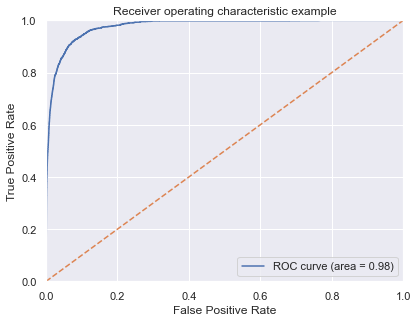

In [36]:
#i'm using cross-validated results onwards

# AUC
y_probabilities = cvp(lregr, X_train_bi, y_bi, method='predict_proba', cv = 10)
get_auc(y_bi, y_probabilities, ["Not Class 7", "Class 7"], column=1, plot=True)

# We know that the higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. 
# In this case, the higher the AUC, the better the model is at distinguishing between covert type 7 with the disease and not cover type 7.
# However, our data is unbalanced so it might be the case that the high AUC comes from the model being really good at predicting not class 7
# so we need to look at other measures to check the performance of our model

[[58416   427]
 [  952  1211]]


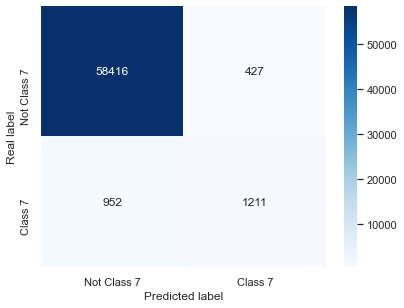

In [37]:
#class predictions
y_hat_cv = cvp(lregr, X_train_bi, y_bi, cv=10)

#confusion matrix - cross validated
cm =  confusion_matrix(y_pred=y_hat_cv, y_true=y_bi, labels=[0,1])
print (cm)
# Plotting confusion matrix 
plot_confusion_matrix(cm, class_labels_bi)

#using cross-validated data, the number of false positives has increased from 425 to 427 
#while te number of false negatives incresed from 942 to 952

In [38]:
#### Accuracy
print ("Accuracy (cross-validated): ", accuracy_score(y_bi, y_pred))

####  Classification report
print (classification_report(y_bi, y_pred))

Accuracy (cross-validated):  0.9773956660000656
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     58843
           1       0.74      0.56      0.64      2163

    accuracy                           0.98     61006
   macro avg       0.86      0.78      0.81     61006
weighted avg       0.98      0.98      0.98     61006



We observe from the classification report above that our of all Cover_Type = 7, we only find more than half. This is expected since our data is very unbalanced. In other words, while our model is good at predicting in general, its performance is bad when predicting the minority class/es.

### Step 6: Report variable impact

In [39]:
print(lregr.coef_)

#while our model imposes l2 penalty, we observe that none of the coefficients have been totally zeroed out.
#but some our quite close to 0

[[ 4.38954938e+00  5.71463942e-02 -2.55846042e-01 -4.51394414e-01
  -1.00868029e-01 -2.15225016e-01 -2.03289132e-01  1.59695446e-01
  -7.30733190e-01  5.08586471e-01  1.17613813e-03  1.37117135e+00
   5.91180510e-01 -1.27896400e-01 -5.31080668e-03  7.84534417e-01
   1.85190907e-01  1.15607407e-01 -4.80511848e-02 -6.87004112e-02
   8.14864622e-02 -5.81681895e-01 -5.20634973e-01 -7.22302409e-01
  -1.96440452e-01  9.45341461e-02 -3.54977927e-01 -2.84710831e-01
  -1.95375798e-01  2.18810556e-03 -6.57098203e-01 -3.40080731e-02
  -1.77990288e-01  4.13859348e-02 -5.48587845e-02 -2.57587348e-01
  -4.07914405e-01  3.30053194e-02 -1.15469189e-01  8.01215690e-01
   4.89306655e-01 -1.68330424e-01 -2.78116586e-01 -1.61175408e-01
   4.01564765e-02  1.17312815e-01  2.35246399e-02  3.22829372e-01
   3.90675138e-01  4.14287273e-01  2.13331024e-01]]


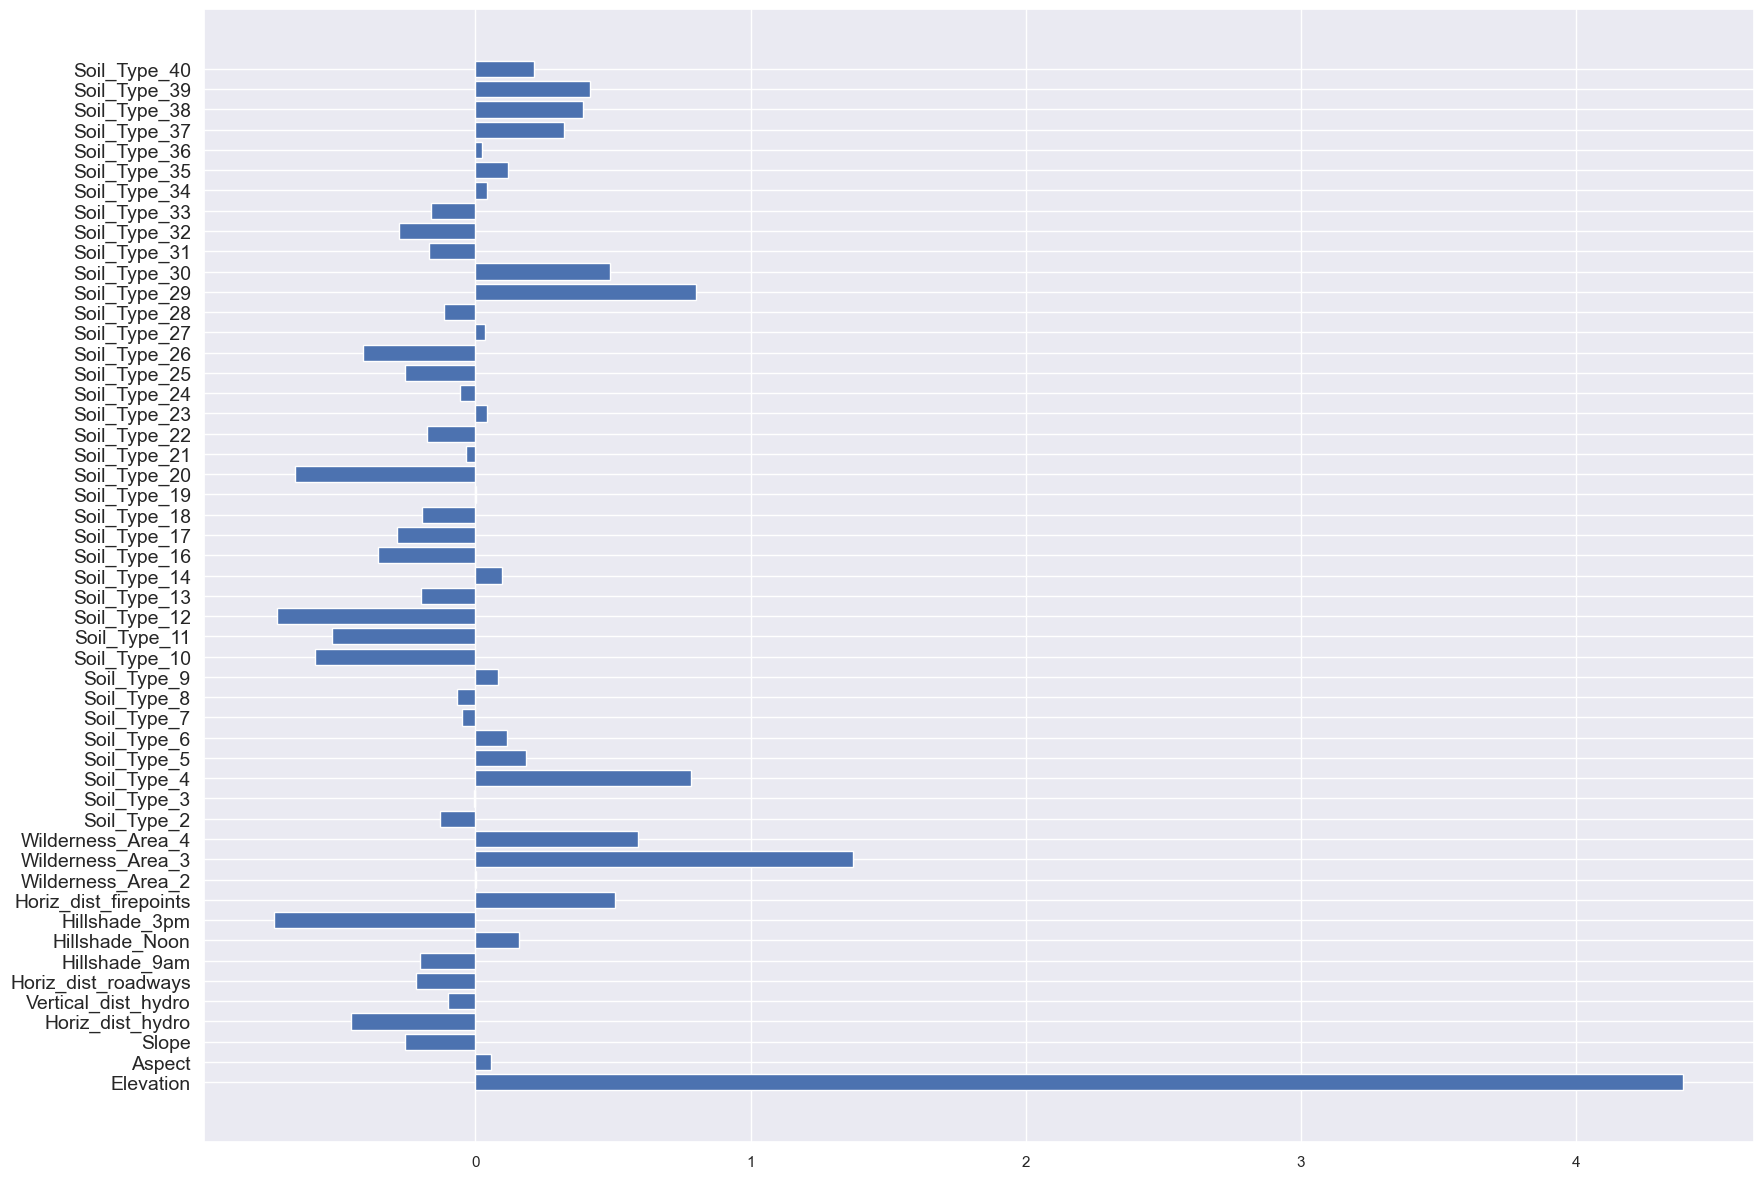

In [40]:
my_coef_plot(X_train_bi,lregr,0)

#the feature that has the highest impact is elevation, with coeffcient 4.4
# This is followed by wilderness area 3, with a coefficient of 1.37
#the higher the elevation, the higher the probability that the Cover_Type is Class 7

## Binary(Unbalanced) - Optimized Parameters #1

### Step 4: Build a binary model to predict class #7

In [69]:
# define model
lregr_opt = LogisticRegression(max_iter=1000)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'liblinear']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(lregr_opt, space, n_iter=60, scoring='accuracy', n_jobs=3, cv=cv, random_state=1, verbose=20)
# execute search
result = search.fit(X_train_bi, y_bi)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 15 folds for each of 60 candidates, totalling 900 fits
Best Score: 0.9774940179429047
Best Hyperparameters: {'C': 6.368370934879298, 'penalty': 'l2', 'solver': 'newton-cg'}


In [72]:
#using the C we got from our grid search
lregr_opt = LogisticRegression(max_iter=1000, penalty = 'l2', solver= 'newton-cg', C=6.368370934879298)
lregr_opt.fit(X_train_bi,y_bi)
y_pred = lregr_opt.predict(X_train_bi)
y_prob = lregr_opt.predict_proba(X_train_bi)

### Step 5: Assess expected accuracy: AUC

AUC:  0.9772808621520571


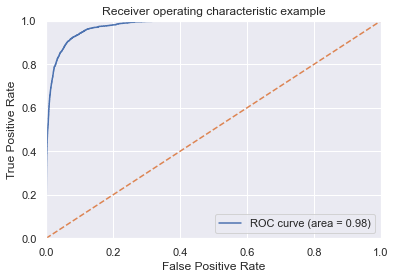

[[58416   427]
 [  953  1210]]


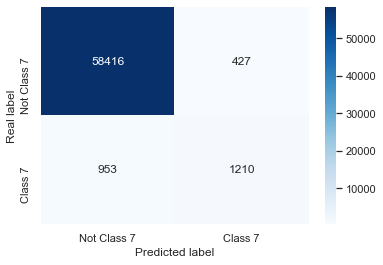

Accuracy (cross-validated):  0.9775923679638069
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     58843
           1       0.74      0.56      0.64      2163

    accuracy                           0.98     61006
   macro avg       0.86      0.78      0.81     61006
weighted avg       0.98      0.98      0.98     61006



In [79]:
# AUC
y_probabilities = cvp(lregr_opt, X_train_bi, y_bi, method='predict_proba', cv = 10)
get_auc(y_bi, y_probabilities, class_labels_bi, column=1, plot=True) 

#The AUC of the from the optimized model is only marginally higher than that of the non-optimzed one one 
# unbalanced/non-optimized: 0.9772101897517415; unbalanced/non-optimized:0.9772808621520571
#difference of around 0.00006


# Confusion matrix
y_hat_cv = cvp(lregr_opt, X_train_bi, y_bi, cv=10)

cm =  confusion_matrix(y_pred=y_hat_cv, y_true=y_bi, labels=[0,1])
print (cm)
# Plotting confusion matrix 
plot_confusion_matrix(cm, class_labels_bi)
#using cross-validation, the numbers in the confusion matrix did not change from that when we used an
#unoptimized parameter

#### Accuracy
print ("Accuracy (cross-validated): ", accuracy_score(y_bi, y_pred))
# the accuracy score marginally increased from 0.9773956660000656 to 0.9775923679638069

####  Classification report
print (classification_report(y_bi, y_pred))

It is important to reiterate that the precision/recall/f-1 score has not improved even after using a tuned parameter. We observe from the confusion matrix and classification report above that our of all Cover_Type = 7, we only find more than half. This is expected since our data is very unbalanced. In other words, while our model is good at predicting in general, its performance is bad when predicting the minority class. 



### Step 6: Report variable impact

[[ 4.38031031e+00  5.73044900e-02 -2.53718757e-01 -4.50883545e-01
  -1.00367312e-01 -2.14564006e-01 -1.95085609e-01  1.55325272e-01
  -7.21287569e-01  5.08080813e-01  1.42670202e-03  1.37000741e+00
  -1.55008874e-02 -1.12511614e-01 -4.65336652e-02  7.71539636e-01
  -1.58267677e-04 -1.13035517e-03 -3.47073044e-02 -4.98049107e-02
  -3.76725810e-03 -4.28814913e-01 -3.79254793e-01 -5.26075238e-01
  -2.09278407e-01 -1.16067797e-03 -2.64657632e-01 -2.07344466e-01
  -1.41616792e-01 -4.36023224e-03 -4.94519121e-01 -3.65325187e-02
  -1.95676003e-01  1.88422234e-02 -6.92763641e-02 -2.07582319e-01
  -3.11082037e-01  2.97445539e-02 -8.34712644e-02  7.69504643e-01
   4.71604210e-01 -1.83759869e-01 -2.99013089e-01 -1.81160539e-01
   3.59837606e-02  1.13187821e-01  2.25720753e-02  2.58868293e-01
   3.78773508e-01  4.02830171e-01  2.04693284e-01]]


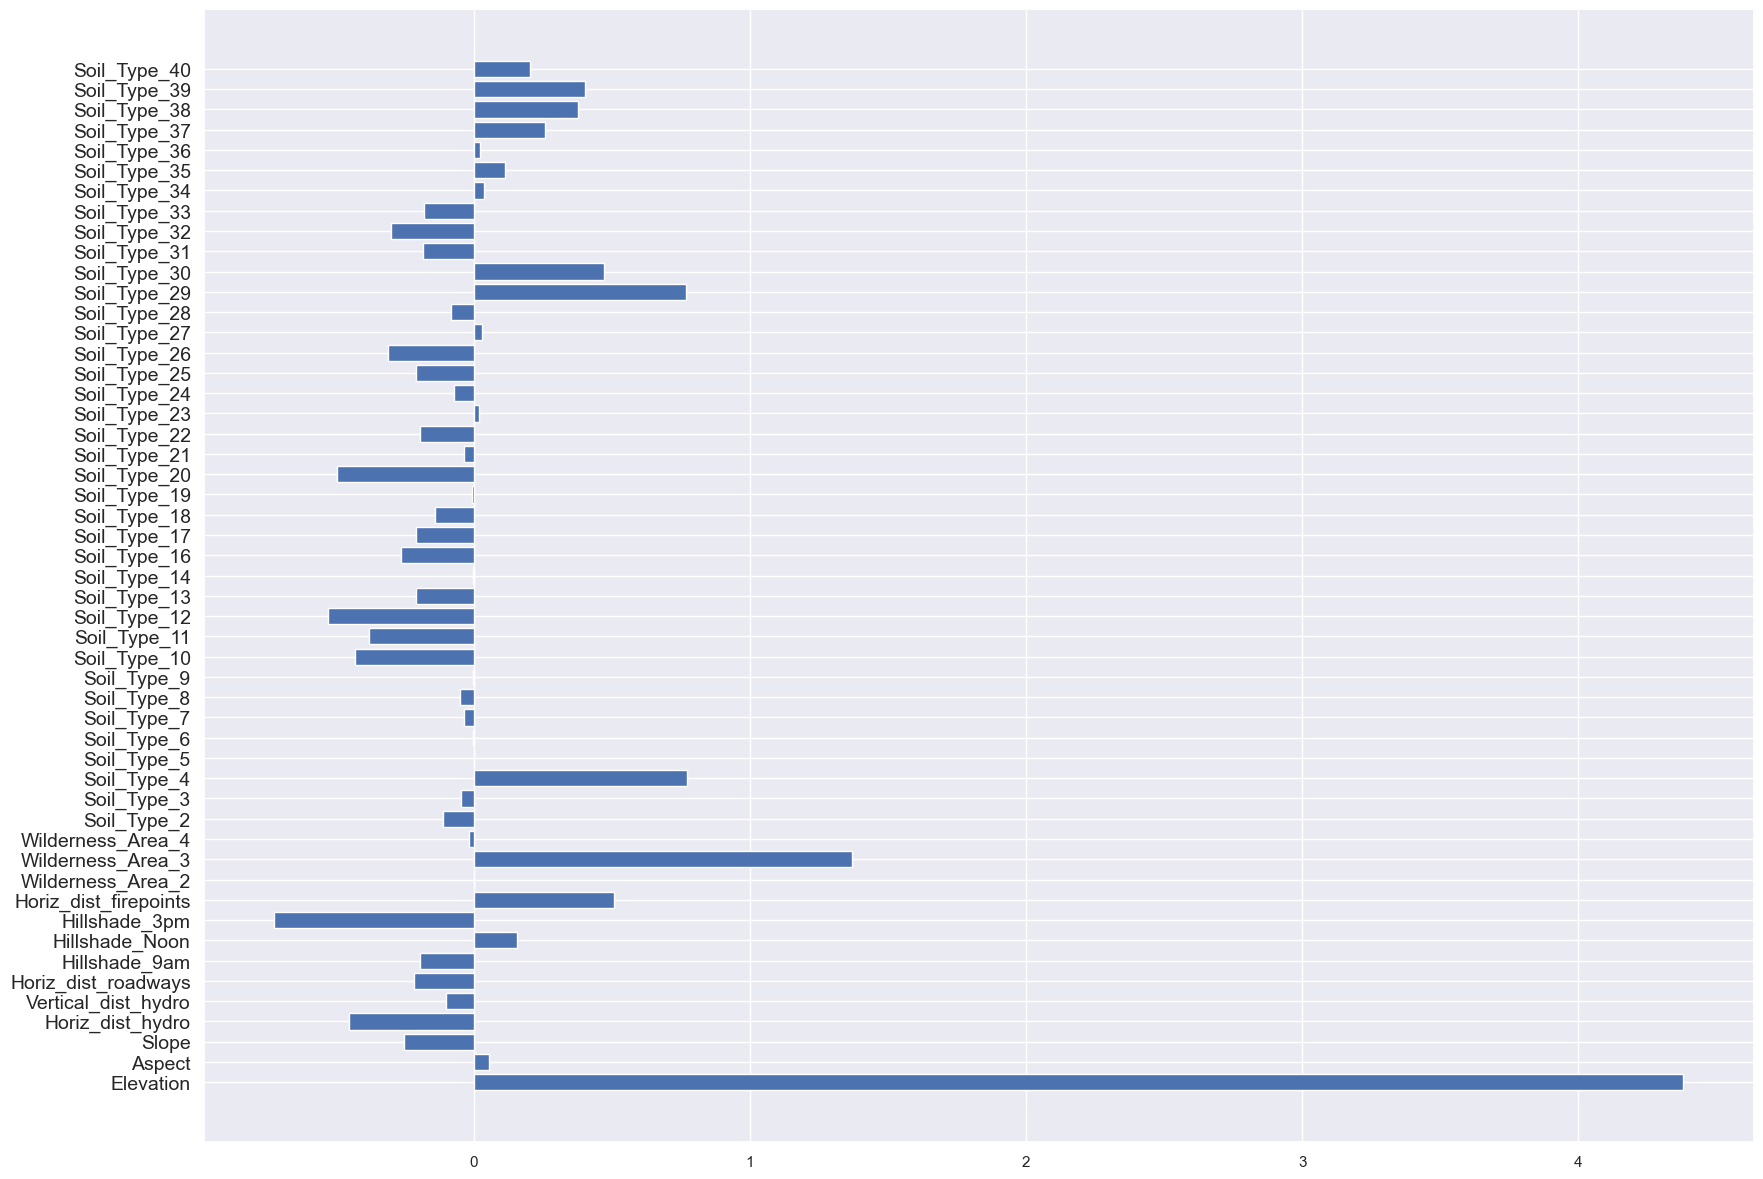

In [82]:
print(lregr_opt.coef_)

#we also graph the coeffcients so that it's easier to see
my_coef_plot(X_train_bi,lregr_opt,0)

#the feature that has the highest impact is elevation, with coeffcient 4.4
# This is followed by wilderness area 3, with a coefficient of 1.37
#the higher the elevation, the higher the probability that the Cover_Type is Class 7

## Step 7: Binary (Balanced) - Optimized 

Step 7: Try to improve it using methods to tackle class imbalance.


### Balancing method 1: Using class_weight='balanced'

In [28]:
#we use the parameter we got from the hyperparameter optimization of the unbalanced data
lregr_balanced = LogisticRegression(penalty='l2', C=6.368370934879298, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='newton-cg', max_iter=500, class_weight='balanced')
lregr_balanced.fit(X_train_bi,y_bi)

LogisticRegression(C=6.368370934879298, class_weight='balanced', max_iter=500,
                   solver='newton-cg')

In [33]:
#save model using joblib
filename = 'lregr_balanced.sav'
#joblib.dump(lregr_balanced, filename)

# load the model from disk
joblib_lregr_balanced = joblib.load(filename)

In [30]:
#in-sample
labels_balanced = lregr_balanced.predict(X_train_bi)
print(labels_balanced)

[1 0 0 ... 0 0 0]


[[54110  4733]
 [  135  2028]]


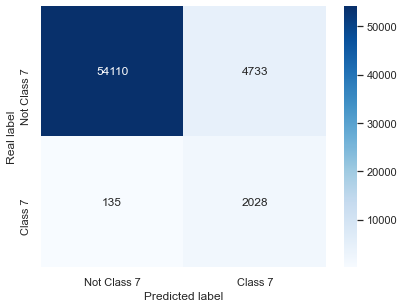

In [34]:
#in-sample
#confusion matrix
cm =  confusion_matrix(y_pred=labels_balanced, y_true=y_bi, labels=[0,1])
print (cm)

my_plot_size_default()
plot_confusion_matrix(cm, class_labels_bi) 

#now, with the balanced model, we make more errors but we identify the smaller class (Class 7) more correctly than in the previous unbalanced model
# from 1211 then to 2028 now (both from in-sample)

In [35]:
y_prob_balanced = lregr_balanced.predict_proba(X_train_bi) 
#note that these probabilities are not correct, so we need to reweight

In [41]:
#reweighting

#insert comment
q1 = y_bi.sum()/len(y_bi)
r1 = 0.5

In [36]:
#reweighted_probs = pd.Series(lregr_balanced.predict_proba(X_train_bi)[:,1]).apply(reweight,args=(q1,r1))
reweighted_probs = pd.Series(joblib_lregr_balanced.predict_proba(X_train_bi)[:,1]).apply(reweight,args=(q1,r1))

In [37]:
reweighted_probs[-10:]

60996    8.103536e-12
60997    1.358124e-04
60998    6.580990e-04
60999    2.769470e-06
61000    6.743006e-06
61001    1.666185e-01
61002    6.426825e-03
61003    1.833546e-04
61004    5.502787e-09
61005    3.621612e-08
dtype: float64

In [39]:
#cross validation
y_hat_cv_balanced = cvp(lregr_balanced, X_train_bi, y_bi, cv=10)

[[54108  4735]
 [  143  2020]]


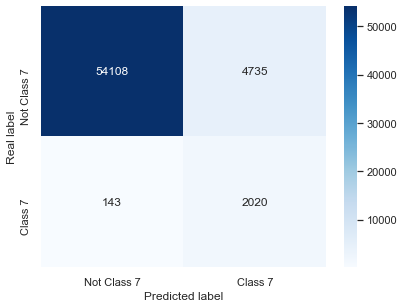

In [40]:
cm =  confusion_matrix(y_pred=y_hat_cv_balanced, y_true=y_bi, labels=[0,1])
print (cm)
# Plotting confusion matrix 
plot_confusion_matrix(cm, class_labels_bi)

#using cross-validated data, the performance of our balanced model (lregr with class_weight='balanced') 
# from 1211 then to 2028 now (both from cross validation (balanced vs imbalanced))
#note that this is a huge improvement from unbalanced to balanced!!

### Step 5: Assess expected accuracy: AUC

AUC:  0.9781356171384666


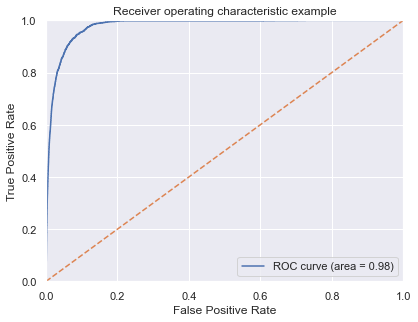

Accuracy (cross-validated):  0.9200406517391732
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     58843
           1       0.30      0.93      0.45      2163

    accuracy                           0.92     61006
   macro avg       0.65      0.93      0.70     61006
weighted avg       0.97      0.92      0.94     61006



In [41]:
#repeating for reweigted
# AUC
y_probabilities = cvp(lregr_balanced, X_train_bi, y_bi, method='predict_proba', cv = 10)
get_auc(y_bi, y_probabilities, ["Not Class 7", "Class 7"], column=1, plot=True) 

# The AUC improved from from 0.9773041341531395 to 0.9781356171384666

#### Accuracy
print ("Accuracy (cross-validated): ", accuracy_score(y_bi, y_hat_cv_balanced))
#accuracy score of the model using cross-validated data is 92%

####  Classification report
print (classification_report(y_bi, y_hat_cv_balanced))
# but if we look at the f1 score (the weighted average of Precision and Recall) for class 1, 
#we see that it is very low, with only 45%
#specifically, it is the precision that is very low, with only 30% 
#(precision is the number of positive class predictions that actually belong to the positive class)
# but we are more concerned with recall. from 0.56, it has increased to 0.93! this means that we are 
#able to identify class 7 with the balanced model much better

With the balanced dataset, recall has improved drastically from 0.56 to 0.93. This means that from predicting correctly only 1 out of 2 in Class 7, we could now predict 9 out of 10.

It is important to note, however, that precision has decreased 0.74 to 0.30. This means that out of all the predictions classified as 1 by our model, only 3 out of 10 are truly Class 7. But since that cover type (Cover Type 7) is a rare valuable habitat, we put more weight on finding Class 7 than identifying other types which are not Class 7 as Class 7.

[[ 5.87775653e+00 -1.66674402e-01 -2.14438571e-01 -5.14230366e-01
   5.43478128e-02 -3.60693975e-01 -1.39205698e+00  1.06715369e+00
  -2.02365845e+00  5.01424344e-01 -2.53757460e-01  9.31868406e-01
  -5.46413768e-02 -8.67167075e-02 -4.03127839e-02  1.01034086e+00
  -4.71146762e-05 -4.55585662e-04 -4.36317793e-02 -6.25392838e-02
  -2.65060239e-03 -4.91160270e-01 -4.02014019e-01 -7.35101252e-01
  -5.80155596e-03 -1.43802508e-04 -3.53451769e-01 -2.12866365e-01
  -1.99435191e-01  2.91206270e-02 -6.57672415e-01 -4.73358782e-02
  -1.38638905e-01  2.61236902e-01  5.21693148e-02 -2.64656558e-01
  -3.56419847e-01 -4.22386863e-03 -1.79335754e-01  7.03425845e-01
   4.56358479e-01 -1.69847499e-01 -3.02111398e-01 -3.36345159e-01
   5.84070932e-02  9.41272559e-02  8.88369309e-03  2.27612146e-01
   4.27292742e-01  3.19344054e-01  1.72974056e-01]]


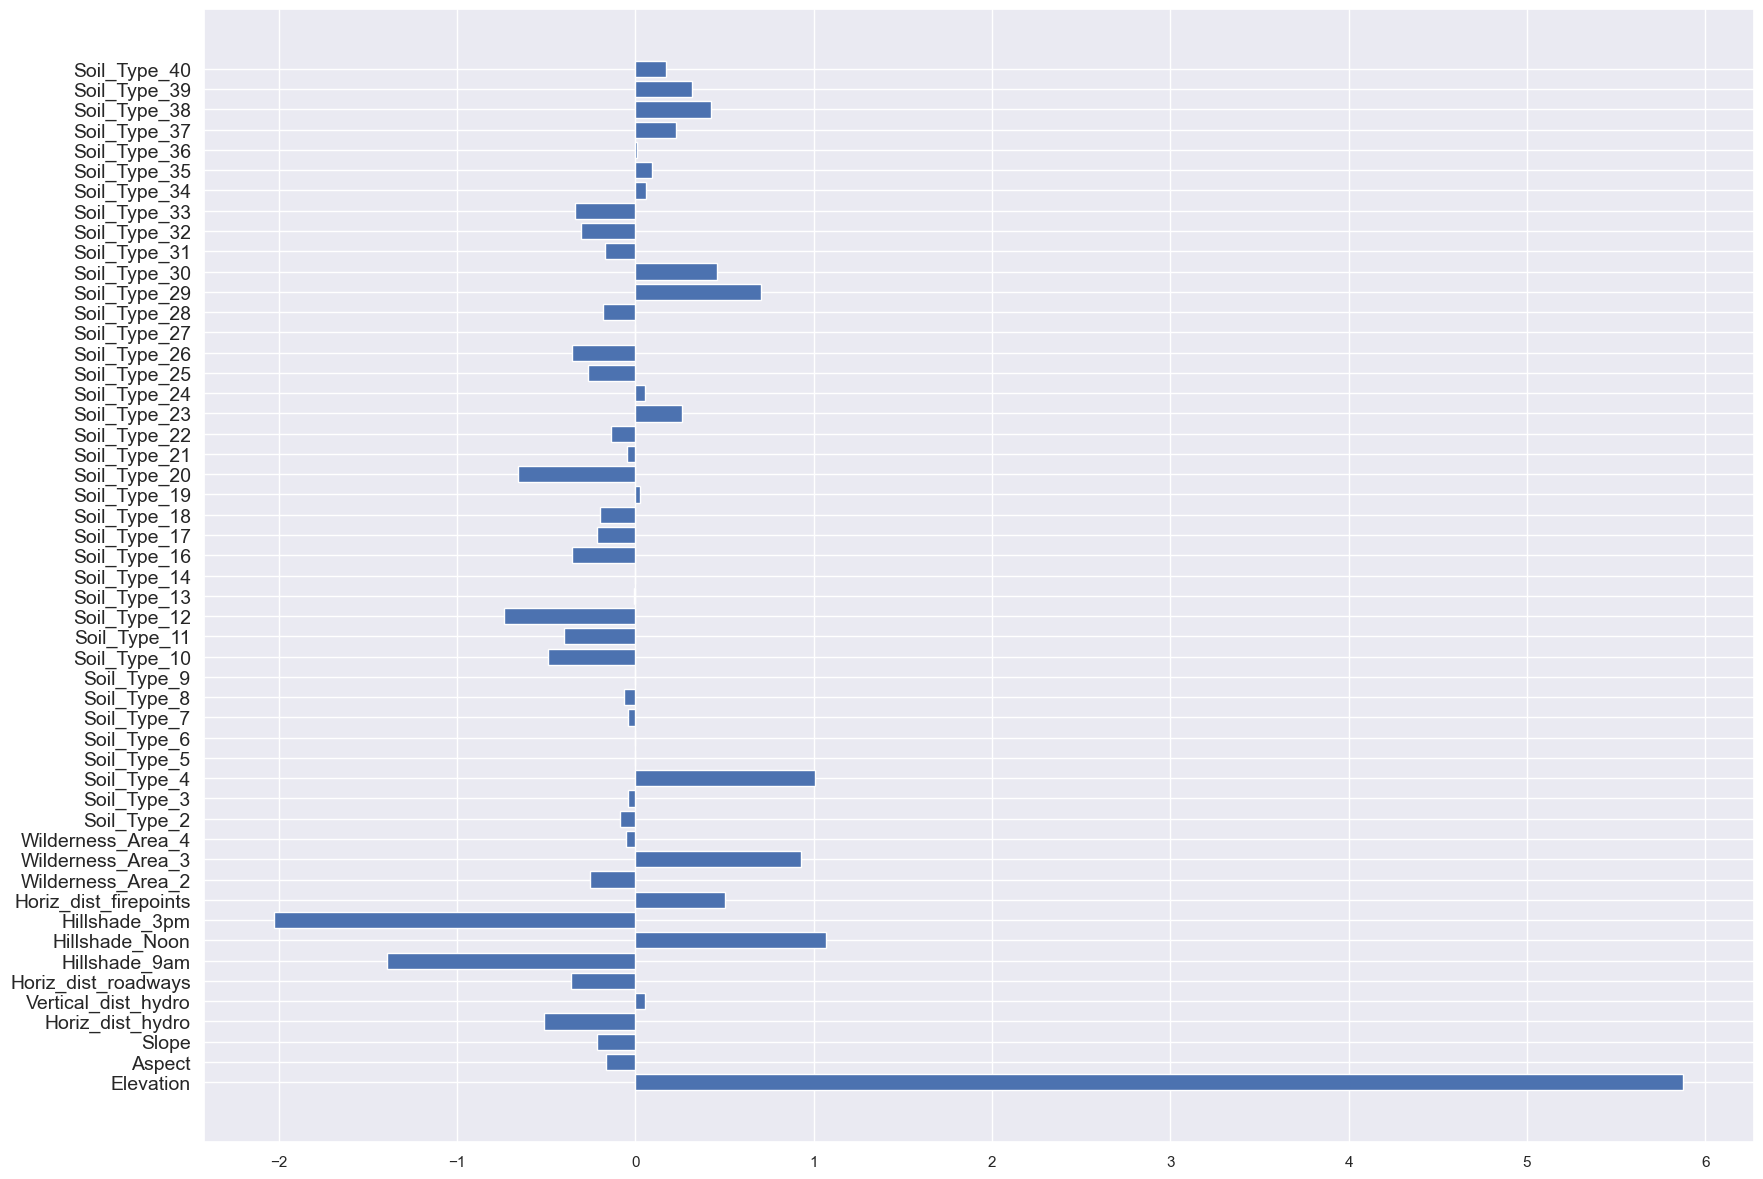

In [44]:
# Step 6: Report variable impact
print(lregr_balanced.coef_)

my_coef_plot(X_train_bi,lregr_balanced,0)

*Creating another model based on a new GridSearch*

In the next cells, I try to do hyperparameter tuning based and fitting using GridSearch. 
Even after conducting a new grid search, the performance of our model has not improved.

In [27]:
#Grid Search
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
grid_values = {'solver': ['liblinear', 'newton-cg'],'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', verbose=50, n_jobs=3)
grid_clf_acc.fit(X_train_bi, y_bi)

#Predict values based on new parameters
#in-sample
y_pred_acc = grid_clf_acc.predict(X_train_bi)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_bi,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_bi,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_bi,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_bi,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(y_bi,y_pred_acc)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Accuracy Score : 0.942907255024096
Precision Score : 0.37149532710280375
Recall Score : 0.8821081830790569
F1 Score : 0.5228113440197287


array([[55615,  3228],
       [  255,  1908]], dtype=int64)

In [38]:
q1 = y_bi.sum()/len(y_bi)
r1 = 0.5
reweighted_probs_a = pd.Series(grid_clf_acc.predict_proba(X_test)[:,1]).apply(reweight,args=(q1,r1))

In [39]:
print(reweighted_probs_a)

0        0.008800
1        0.001011
2        0.403385
3        0.000101
4        0.001724
           ...   
13068    0.007522
13069    0.002484
13070    0.002105
13071    0.001370
13072    0.198800
Length: 13073, dtype: float64


### Balancing Method 2: SMOTE

In [43]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train_bi, y_bi)

y_sm.value_counts()

0    58843
1    58843
Name: Cover_Type, dtype: int64

In [44]:
#Using unoptmized parameter for model fitting

#specifying parameters/specificiations of our logistic regression)
lregr_sm = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=500)

#fitting our first binary model
#note that this model does not correct for class imbalance
lregr_sm.fit(X_sm,y_sm)  

lregr_sm.predict(X_sm)  
lregr_sm.predict_proba(X_sm)  

array([[6.83718746e-02, 9.31628125e-01],
       [9.97309455e-01, 2.69054544e-03],
       [9.99999605e-01, 3.95233878e-07],
       ...,
       [1.87636105e-01, 8.12363895e-01],
       [3.68845037e-03, 9.96311550e-01],
       [1.17647215e-03, 9.98823528e-01]])

In [45]:
#doing hyperparameter optimization on the oversampled dataset, which I am not sure if it's correct or not

# define model
lregr_sm_opt = LogisticRegression(max_iter=1000)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['liblinear'] #have also included newton-cg before
space['penalty'] = ['l2'] #have also included l1 penalization before
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(lregr_sm_opt, space, n_iter=30, scoring='accuracy', n_jobs=3, cv=cv, random_state=1, verbose=20)
# execute search
result = search.fit(X_sm, y_sm)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Best Score: 0.9345376608651408
Best Hyperparameters: {'C': 0.08143831871427488, 'penalty': 'l2', 'solver': 'liblinear'}


In [46]:
#specifying parameters/specificiations of our logistic regression)
lregr_sm_opt = LogisticRegression(penalty='l2', C=0.08143831871427488, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           solver='liblinear', max_iter=1000)

#fitting our first binary model
#note that this model does not correct for class imbalance
lregr_sm_opt.fit(X_sm,y_sm)  

y_pred = lregr_sm_opt.predict(X_sm)  
y_prob =lregr_sm_opt.predict_proba(X_sm)

In [47]:
#save model using joblib
filename = 'lregr_sm_opt.sav'
joblib.dump(lregr_sm_opt, filename)

# load the model from disk
joblib_model = joblib.load(filename)

In [48]:
y_pred = lregr_sm_opt.predict(X_test)

In [49]:
y_prob = lregr_sm_opt.predict_proba(X_test) # standard prediction
#y_prob = pd.Series(lregr_balanced.predict_proba(X_test)[:,1]).apply(reweight,args=(q1,r1))

In [50]:
y_prob.shape

(13073, 2)

In [51]:
print(y_prob)

[[9.58212438e-01 4.17875620e-02]
 [9.98862804e-01 1.13719579e-03]
 [3.77952555e-02 9.62204745e-01]
 ...
 [9.97551438e-01 2.44856175e-03]
 [9.99949711e-01 5.02892000e-05]
 [1.45744927e-01 8.54255073e-01]]


### Step 9: Produce .csv for kaggle testing (Applying to test data)

In [136]:
#on external / never before seen data
#now we use the test dataset to export results to Kaggle

In [191]:
test_predictions_submit = pd.DataFrame({"Index": test_orig["Index"], "Cover_Type": reweighted_probs})
test_predictions_submit.to_csv("test_LogReg_predictions_submit.csv", index = False)

# Multinomial Classification

## Multinomial (Unbalanced)

### Step 8: Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)

In [61]:
#re-examining our dataset

In [62]:
X_train_multi = X_train.drop(['Cover_Type'], axis=1)

In [63]:
X_train_multi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.869608,-1.089548,-0.549948,-1.267979,-0.798254,0.262324,0.262693,-0.259695,-0.224995,-0.186425,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,6.048836,-0.157516,-0.121675
1,0.552827,0.844259,-0.152141,-0.362494,-0.113321,2.082645,-0.773196,1.297340,1.364189,0.436970,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
2,-0.557684,-0.706351,-0.682551,1.137217,-0.507158,-0.399145,0.743641,-0.008560,-0.537621,-0.677700,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
3,0.737912,-0.661793,-0.682551,0.236447,0.160652,1.627565,0.780637,0.091894,-0.485516,-0.400551,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
4,0.321471,1.575006,-0.417346,-0.683187,-0.267431,0.302704,-0.588216,0.142121,0.712884,-0.997370,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675


In [64]:
y_multi = train_orig['Cover_Type']
y_multi.value_counts() #we observe that most observations are not class 7

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

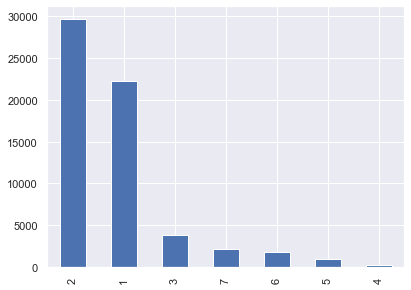

In [46]:
my_plot_size_default()
my_count_plot(train,'Cover_Type')

#we observe that most observations belong to class 2  and class 1
#therefore, we need to balance this later on
# At first, I thought that I would use SMOTE
#But I later realized that SMOTE is impractical for high-dimensional data
#so we need to do some random under sampling

#but first, let's check the results for unbalanced data

### Step 4: Build a multinomial model to predict each class

In [16]:
#note that I use "class" and "cover type" interchangeably

feature_names = X_train_multi.columns
class_labels_multi = ["1","2","3","4","5","6","7"] 

In [50]:
# multinomial-logistic regression for cover type
#model = LogisticRegression(C=100,multi_class="multinomial",solver="newton-cg",max_iter=100000) 
model = LogisticRegression(C=1.5,multi_class="multinomial",solver="newton-cg",max_iter=10000, warm_start=True)
model.fit(X_train_multi,y_multi)

LogisticRegression(C=1.5, max_iter=10000, multi_class='multinomial',
                   solver='newton-cg', warm_start=True)

In [51]:
#save model using joblib
filename = 'model.sav'
#joblib.dump(model, filename)

# load the model from disk
joblib_model = joblib.load(filename)

In [52]:
#y_pred = model.predict(X_train_multi)
y_pred = joblib_model.predict(X_train_multi)

### Step 5: Assess expected accuracy: AUC

In [53]:
# AUC
#cvs(model, X_train_multi, y_multi, cv = 5, scoring='roc_auc_ovr').mean()
cvs(joblib_model, X_train_multi, y_multi, cv = 5, scoring='roc_auc_ovr').mean()

0.9362007665651895

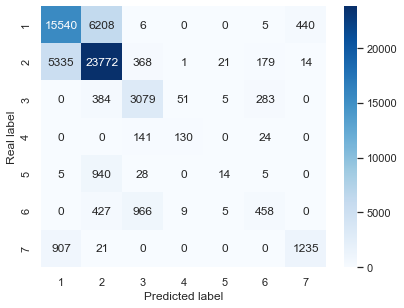

In [54]:
#y_pred = cvp(model, X_train_multi, y_multi, cv = 5) ## by default this gives labels
labels_multi = [1,2,3,4,5,6,7]
y_pred = cvp(joblib_model, X_train_multi, y_multi, cv = 5)
cm =  confusion_matrix(y_pred=y_pred, y_true=y_multi, labels=labels_multi)
# Plotting confusion matrix (custom help function)
plot_confusion_matrix(cm, class_labels_multi) 

In [55]:
####  Classification report
print (classification_report(y_multi, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.70      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.67      0.81      0.73      3802
           4       0.68      0.44      0.53       295
           5       0.31      0.01      0.03       992
           6       0.48      0.25      0.32      1865
           7       0.73      0.57      0.64      2163

    accuracy                           0.72     61006
   macro avg       0.62      0.51      0.53     61006
weighted avg       0.71      0.72      0.72     61006



We observe from the classification report that although our model is pretty good at preidcting Classes 1 to 3 (with f1-scores more than 70%), we see that for other cover types, predictions are not good. Class 7 and Class 4 has an f1-score of 0.64 and 0.53 respectively (which could still be considered as okay). Class 6 has an f1-score of 0.32, while our predictions for class 5 is the worst, with it having an f1 score of 0.03 with 0.01 recall how many of the true positives were recalled/found.

### Step 6: Report variable impact

In [153]:
print(model.coef_)

[[ 3.21049666e+00 -1.56781515e-01  4.03836780e-02 -2.08178183e-01
  -2.35414781e-01 -4.47227014e-01 -3.12890284e-01 -3.45807831e-01
   1.76168789e-01 -3.29636045e-01  1.51005200e-01 -1.16222012e+00
  -1.24631570e+00 -6.14074805e-01 -3.68758947e-01 -4.18931440e-01
  -2.97758444e-02 -2.11410347e-01 -6.85208102e-02  1.91066512e-02
   1.67672559e-01 -9.81630458e-02 -4.22495127e-02  3.55713830e-01
  -1.09769252e-01 -4.96792690e-02  8.30241485e-03 -9.47772549e-02
   7.29066501e-02  5.14192096e-02  2.45188710e-01  9.77932835e-02
   4.50343995e-01  1.70615116e-01  1.45139836e-01  1.11990231e-02
   8.99156617e-02  4.82735306e-02  1.22775026e-01 -1.13883584e-01
  -1.09753347e-01  1.78502565e-01 -1.84576367e-01  1.21473594e-01
  -7.91599461e-02  1.54475251e-02 -1.85775822e-02 -1.07717625e-01
  -4.91083974e-02  4.08688450e-02 -2.65094032e-02]
 [ 8.88727456e-01 -1.49860294e-01  1.19234003e-01  1.85660482e-01
  -1.76246492e-01 -2.99127060e-01 -6.54281878e-01  4.38374880e-01
  -4.58819594e-01 -3.6555

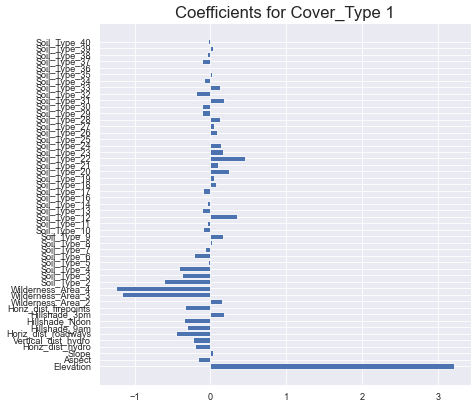

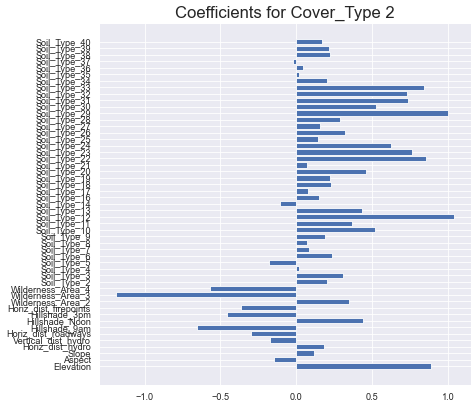

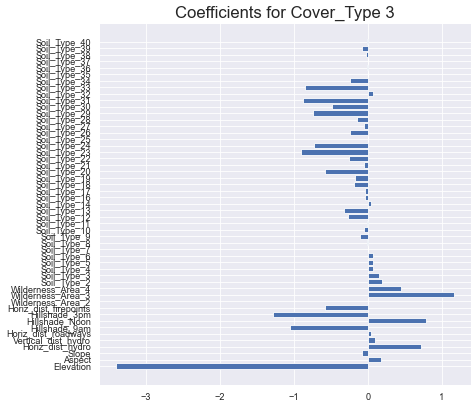

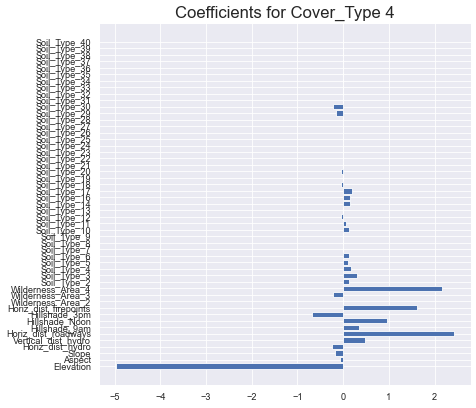

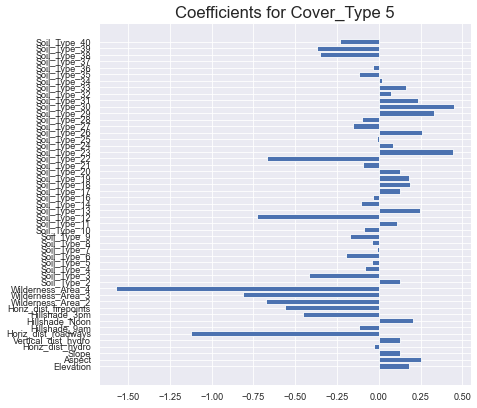

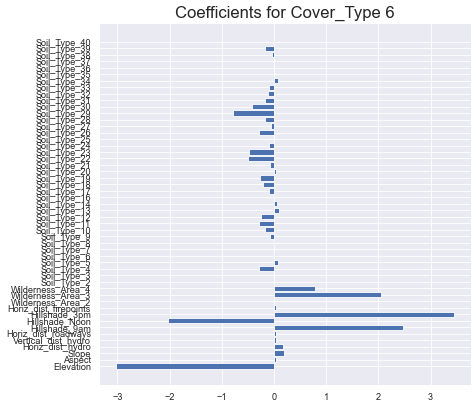

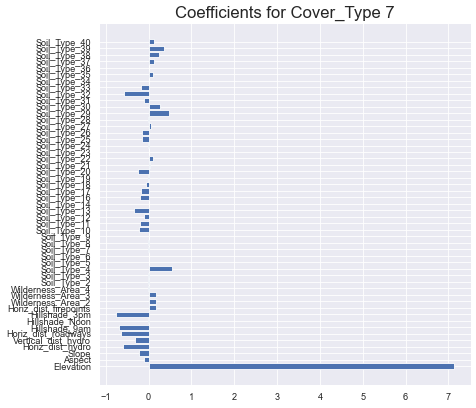

In [75]:
for i in range (7):
    my_coef_plot_multi(X_train_multi,joblib_model,i)
    
# for type 1, the feature that has the highest impact is elevation, followed by wilderness area 4 and 3
#for type 2, the feature that has the highest impact the dummy for wilderness area type 3
#for type 3, 4 and 7, the feature that has the highest impact is the elevation
# for type 5, the feature that has the highest impact is the dummy wilderness_area=4 dummy
# for type 6, the feature that has the highest impact is Hillshade_3PM

In [177]:
# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 10)
# define search
search = RandomizedSearchCV(model, space, n_iter=10, scoring='accuracy', n_jobs=3, cv=cv, random_state=1,verbose=10)
# execute search
result = search.fit(X_train_multi, y_multi)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.7249205647506651
Best Hyperparameters: {'C': 0.20986835607646592, 'penalty': 'l2', 'solver': 'newton-cg'}


In [182]:
model_a = LogisticRegression(C=0.20986835607646592,multi_class="multinomial",solver="newton-cg",max_iter=2000, intercept_scaling=1)

model_a.fit(X_train_multi, y_multi)

LogisticRegression(C=0.20986835607646592, max_iter=2000,
                   multi_class='multinomial', solver='newton-cg')

In [183]:
y_pred = model_a.predict(X_train_multi)

### Step 5: Assess expected accuracy

In [186]:
# AUC
cvs(model_a, X_train_multi, y_multi, cv = 5, scoring='roc_auc_ovr').mean()

0.9358993757245466

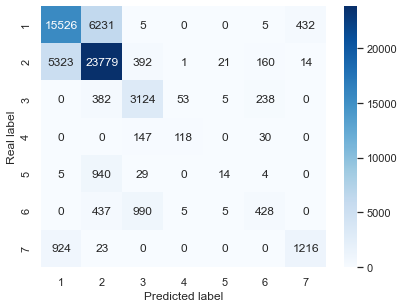

In [187]:
#For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes
#(check metrics.confusion_matrix and metrics.classification_report in sklearn)

y_pred = cvp(model_a, X_train_multi, y_multi, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_multi, labels=labels_multi)
# Plotting confusion matrix (custom help function)
plot_confusion_matrix(cm, class_labels_multi) 

In [188]:
####  Classification report
print (classification_report(y_multi, y_pred))

#even with the optimized parameter, the overall performance of our model did not improve

              precision    recall  f1-score   support

           1       0.71      0.70      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.67      0.82      0.74      3802
           4       0.67      0.40      0.50       295
           5       0.31      0.01      0.03       992
           6       0.49      0.23      0.31      1865
           7       0.73      0.56      0.64      2163

    accuracy                           0.72     61006
   macro avg       0.62      0.50      0.53     61006
weighted avg       0.71      0.72      0.71     61006



In [ ]:
#model_c with optimized parameter from grid search so much more iterations 
#search for model_c laster for a day
# i think this got the highest score in kaggle

In [166]:
# define model
model_c = LogisticRegression(max_iter=1000, warm_start=True)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model_c, space, n_iter=150, scoring='accuracy', n_jobs=3, cv=cv, random_state=1, verbose=100)
# execute search
result = search.fit(X_train_multi, y_multi)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 15 folds for each of 150 candidates, totalling 2250 fits
Best Score: 0.725262065469943
Best Hyperparameters: {'C': 10.47600364305654, 'penalty': 'l2', 'solver': 'newton-cg'}


In [170]:
model_c = LogisticRegression(max_iter=1000, warm_start=True, C= 10.47600364305654, penalty='l2', solver = 'newton-cg')

In [171]:
model_c.fit(X_train_multi, y_multi)

LogisticRegression(C=10.47600364305654, max_iter=1000, solver='newton-cg',
                   warm_start=True)

In [172]:
y_pred = model_c.predict(X_train_multi)

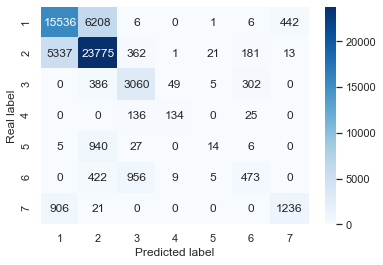

In [173]:
y_pred = cvp(model_c, X_train_multi, y_multi, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_multi, labels=labels_multi)
# Plotting confusion matrix (custom help function)
plot_confusion_matrix(cm, class_labels_multi) 

In [174]:
####  Classification report
print (classification_report(y_multi, y_pred))

#even with the optimized parameter, the overall performance of our model did not improve
# all the more we need to tackle class imbalance

              precision    recall  f1-score   support

           1       0.71      0.70      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.67      0.80      0.73      3802
           4       0.69      0.45      0.55       295
           5       0.30      0.01      0.03       992
           6       0.48      0.25      0.33      1865
           7       0.73      0.57      0.64      2163

    accuracy                           0.72     61006
   macro avg       0.62      0.51      0.54     61006
weighted avg       0.71      0.72      0.72     61006



### Applying to Test Data

In [192]:
y_hat = model_a.predict(X_test)

In [193]:
print(y_hat)

[1 2 7 ... 2 2 1]


### Step 9: Produce .csv for kaggle testing 

In [195]:
test_predictions_submit = pd.DataFrame({"Index": test_orig["Index"], "Cover_Type": y_hat})
test_predictions_submit.to_csv("test_LogReg_predictions_submit.csv", index = False)

## Multinomial (Balanced)

### Step 7: Try to improve it using methods to tackle class imbalance.

In [196]:
columns = X_train_multi.columns

feature_names = X_train_multi.columns
print(class_labels_multi)

### Balancing method 1: Using class_weight=balanced

In [585]:
model_balanced = LogisticRegression(C=10.47600364305654,multi_class="multinomial",solver="newton-cg",max_iter=10000, intercept_scaling=1, class_weight='balanced')
# we've use the hyperparameter we got from before
model_balanced.fit(X_train_multi,y_multi)

LogisticRegression(C=100, class_weight='balanced', max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

In [212]:
#save model using joblib
import joblib
filename = 'model_balanced.sav'
joblib.dump(model_balanced, filename)

In [198]:
# load the model from disk
joblib_model_balanced = joblib.load(filename)

In [201]:
# in-sample
y_pred = joblib_model_balanced.predict(X_train_multi)

### Step 5: Assess expected accuracy

In [202]:
# AUC
cvs(joblib_model_balanced, X_train_multi, y_multi, cv = 10, scoring='roc_auc_ovr').mean()

0.9362295776340723

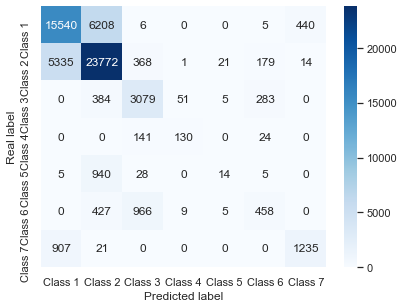

In [204]:
y_pred = cvp(joblib_model_balanced, X_train_multi, y_multi, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_multi, labels=labels_multi)

plot_confusion_matrix(cm, class_labels_multi) 
# it is a bit difficult to interpret the confusion matrix of a multinomial model
# but the number are still similar
# meaning even after using class_weight = 'balanced', our predictions did not improve

In [205]:
####  Classification report
print (classification_report(y_multi, y_pred))

#the balanced model did not show improvements in accuracy
#f-1 score for each type stayed the same

              precision    recall  f1-score   support

           1       0.71      0.70      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.67      0.81      0.73      3802
           4       0.68      0.44      0.53       295
           5       0.31      0.01      0.03       992
           6       0.48      0.25      0.32      1865
           7       0.73      0.57      0.64      2163

    accuracy                           0.72     61006
   macro avg       0.62      0.51      0.53     61006
weighted avg       0.71      0.72      0.72     61006



In [206]:
# Step 6: Report variable impact
print(joblib_model_balanced.coef_)

[[ 3.21049666e+00 -1.56781515e-01  4.03836780e-02 -2.08178183e-01
  -2.35414781e-01 -4.47227014e-01 -3.12890284e-01 -3.45807831e-01
   1.76168789e-01 -3.29636045e-01  1.51005200e-01 -1.16222012e+00
  -1.24631570e+00 -6.14074805e-01 -3.68758947e-01 -4.18931440e-01
  -2.97758444e-02 -2.11410347e-01 -6.85208102e-02  1.91066512e-02
   1.67672559e-01 -9.81630458e-02 -4.22495127e-02  3.55713830e-01
  -1.09769252e-01 -4.96792690e-02  8.30241485e-03 -9.47772549e-02
   7.29066501e-02  5.14192096e-02  2.45188710e-01  9.77932835e-02
   4.50343995e-01  1.70615116e-01  1.45139836e-01  1.11990231e-02
   8.99156617e-02  4.82735306e-02  1.22775026e-01 -1.13883584e-01
  -1.09753347e-01  1.78502565e-01 -1.84576367e-01  1.21473594e-01
  -7.91599461e-02  1.54475251e-02 -1.85775822e-02 -1.07717625e-01
  -4.91083974e-02  4.08688450e-02 -2.65094032e-02]
 [ 8.88727456e-01 -1.49860294e-01  1.19234003e-01  1.85660482e-01
  -1.76246492e-01 -2.99127060e-01 -6.54281878e-01  4.38374880e-01
  -4.58819594e-01 -3.6555

### Balancing method 2: Using a mix of oversampling and undersampling while preserving the hierarchy in the number of observations per type

I will be using a mix of oversampling and under sampling while preserving the hierarchy of number of observations. This means that although I recognize that observations in Classes 2 and 1 really outnumber that of other classes, I do not want my model to be train on data that does not know which classes are truly the most common or least uncommon in the dataset / real world.

In [80]:
y_multi_df = pd.DataFrame(y_multi)
X_train = pd.concat([X_train_multi, y_multi_df], axis=1)
#note that the X_train datset includes labels

In [81]:
X_train.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,0.869608,-1.089548,-0.549948,-1.267979,-0.798254,0.262324,0.262693,-0.259695,-0.224995,-0.186425,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,6.048836,-0.157516,-0.121675,1
1,0.552827,0.844259,-0.152141,-0.362494,-0.113321,2.082645,-0.773196,1.297340,1.364189,0.436970,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,2
2,-0.557684,-0.706351,-0.682551,1.137217,-0.507158,-0.399145,0.743641,-0.008560,-0.537621,-0.677700,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,2
3,0.737912,-0.661793,-0.682551,0.236447,0.160652,1.627565,0.780637,0.091894,-0.485516,-0.400551,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,1
4,0.321471,1.575006,-0.417346,-0.683187,-0.267431,0.302704,-0.588216,0.142121,0.712884,-0.997370,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,1


In [82]:
X_train.shape

(61006, 52)

In [88]:
# Divide by class/type
#types = X_train['Cover_Type'].unique()

#transform this into a for loop

df_type_1 = X_train[X_train['Cover_Type'] == 1]
df_type_2 = X_train[X_train['Cover_Type'] == 2]
df_type_3 = X_train[X_train['Cover_Type'] == 3]
df_type_4 = X_train[X_train['Cover_Type'] == 4]
df_type_5 = X_train[X_train['Cover_Type'] == 5]
df_type_6 = X_train[X_train['Cover_Type'] == 6]
df_type_7 = X_train[X_train['Cover_Type'] == 7]

In [86]:
#for i in range (8):
    #df_type_i = X_train[X_train['Cover_Type'] == i]

In [89]:
# Class count
#count_type_1, count_type_2, count_type_3, count_type_4, count_type_5, count_type_6, count_type_7 = 
X_train.Cover_Type.value_counts()
#print(count_type_2)
#we observe that Cover Types 1 and 2 have the most observations

#from this, i will make the observations in each class more or less equal by doing both undersampling and oversampling
#Undersampling
#Since class 2 has almost half of the total obsrvations, I would resample it by dividing it by 2.5
#Since class 1 has the secondmost highest number of observations, I would resample it and get only the third

#Oversampling - since the following categories have relatively few observations
#I will resample class 3 so that it will have 40% more observations
#I will resample class 7 so that it will have 75% more observations
#I will resample class 6 so that it will have 80% more observations
#I will resample class 5 so that it will have 100% more observations (double)
#I will resample class 4 so that it will have 200% more observations (triple)

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

In [94]:
#put the number of observations per cover_type into a list
list1 = []
list1.append(X_train.Cover_Type.value_counts())

In [98]:
for i in list1:
    print(i)

print(list1)

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64
[2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64]


In [108]:
list2 = [0.4, 0.333333, 1.4, 1.75, 1.8, 2.5, 4]
products = []

for num1, num2 in zip(list1, list2):
	products.append(num1 * num2)

print(products)

[2    11876.0
1     8879.6
3     1520.8
7      865.2
6      746.0
5      396.8
4      118.0
Name: Cover_Type, dtype: float64]


In [113]:
#transform this into a for loop

print('The new number of for resampled Class 2 is', 29690/2.5)
print('The new number of for resampled Class 1 is', 22199/3)
print('The new number of for resampled Class 3 is', 3802*1.4)
print('The new number of for resampled Class 7 is', 2163*1.75)
print('The new number of for resampled Class 6 is', 1865*1.8)
print('The new number of for resampled Class 5 is', 992*2.5)
print('The new number of for resampled Class 4 is', 295*4)

The new number of for resampled Class 2 is 11876.0
The new number of for resampled Class 1 is 7399.666666666667
The new number of for resampled Class 3 is 5322.799999999999
The new number of for resampled Class 7 is 3785.25
The new number of for resampled Class 6 is 3357.0
The new number of for resampled Class 5 is 2480.0
The new number of for resampled Class 4 is 1180


In [114]:
# Undersample types 1 and 2
df_type_2_under = df_type_2.sample(11876)
df_type_1_under = df_type_1.sample(7399)

# Oversample other types
df_type_3_over = df_type_3.sample(5322, replace= True, random_state=23)
df_type_7_over = df_type_7.sample(3785, replace= True, random_state=24)
df_type_6_over = df_type_6.sample(3357, replace= True, random_state=48)
df_type_5_over = df_type_5.sample(2480, replace= True, random_state=123)
df_type_4_over = df_type_4.sample(1180, replace= True, random_state=88)

In [115]:
#concat the DataFrames of both class
X_train_under_over = pd.concat([df_type_2_under , df_type_1_under, df_type_3_over, df_type_7_over, df_type_6_over, df_type_5_over, df_type_4_over], axis=0)

In [116]:
X_train_under_over.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
32630,0.118589,-1.374717,0.245666,-0.546420,-0.370171,1.110953,-0.588216,-0.761964,0.113684,-0.728574,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,2
21362,-0.301412,-1.151928,-0.682551,0.189287,-0.404418,0.084779,0.188701,-0.109014,-0.068681,0.499993,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,2
32883,-0.005988,-0.207304,0.245666,-0.126690,-0.353048,0.086702,1.187593,0.343029,-0.876299,0.532643,...,-0.313303,3.441812,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,2
8991,-1.483110,1.557183,-0.284743,-0.702051,-0.712637,-0.581818,-0.810192,0.041667,0.791041,1.808287,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,2
60284,-0.166157,0.407593,1.969498,-0.442667,-0.729761,0.030297,-0.699204,1.347567,0.817093,-0.304878,...,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675,2


In [117]:
X_train_under_over.shape
#we've reduced the number of total observations from more than 60k to arounf 35k

(35399, 52)

In [118]:
X_train_under_over.Cover_Type.value_counts()

2    11876
1     7399
3     5322
7     3785
6     3357
5     2480
4     1180
Name: Cover_Type, dtype: int64

In [119]:
#we separate the dataframe to y and X
y_under_over = X_train_under_over['Cover_Type']
X_train_under_over = X_train_under_over.drop(['Cover_Type'], axis=1)

In [120]:
X_train_under_over.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
32630,0.118589,-1.374717,0.245666,-0.546420,-0.370171,1.110953,-0.588216,-0.761964,0.113684,-0.728574,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
21362,-0.301412,-1.151928,-0.682551,0.189287,-0.404418,0.084779,0.188701,-0.109014,-0.068681,0.499993,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
32883,-0.005988,-0.207304,0.245666,-0.126690,-0.353048,0.086702,1.187593,0.343029,-0.876299,0.532643,...,-0.214774,-0.313303,3.441812,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
8991,-1.483110,1.557183,-0.284743,-0.702051,-0.712637,-0.581818,-0.810192,0.041667,0.791041,1.808287,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
60284,-0.166157,0.407593,1.969498,-0.442667,-0.729761,0.030297,-0.699204,1.347567,0.817093,-0.304878,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675


In [233]:
# define model
model = LogisticRegression(warm_start=True, multi_class='multinomial')
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-5, 15)
# define search
search = RandomizedSearchCV(model, space, n_iter=25, scoring='accuracy', n_jobs=3, cv=cv, random_state=1, verbose=25)
# execute search
result = search.fit(X_train_under_over, y_under_over)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.38369733        nan 0.60864704        nan        nan
        nan        nan 0.66434065        nan 0.67973656 0.68034394
        nan        nan        nan 0.68102187 0.64100662        nan
        nan        nan        nan        nan        nan        nan
        nan]
  warnings.warn(


Best Score: 0.6810218674155994
Best Hyperparameters: {'C': 8.241630776305316, 'penalty': 'l2', 'solver': 'newton-cg'}


In [236]:
#We fit a model based on this "more balanced" data
model_under_over = LogisticRegression(C=0.6810218674155994,multi_class="multinomial",solver="newton-cg",max_iter=10000, intercept_scaling=1)

model_under_over.fit(X_train_under_over, y_under_over)

LogisticRegression(C=0.6810218674155994, max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

In [239]:
filename = 'model_under_over.sav'
joblib_model_under_over =joblib.dump(model_under_over, filename)

In [240]:
y_pred = model_under_over.predict(X_train_under_over)

In [241]:
# AUC
cvs(model_under_over, X_train_multi, y_multi, cv = 10, scoring='roc_auc_ovr').mean()

0.936184096023904

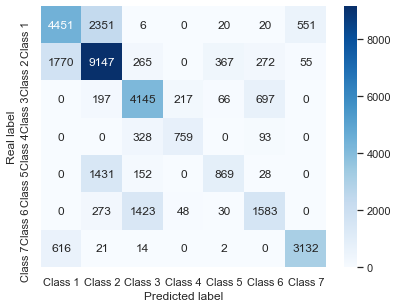

In [243]:
y_pred = cvp(model_under_over, X_train_under_over, y_under_over, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_under_over, labels=[1,2,3,4,5,6,7])
# Plotting confusion matrix (custom help function)
plot_confusion_matrix(cm, class_labels_multi) 

In [244]:
####  Classification report
print (classification_report(y_under_over, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.60      0.63      7399
           2       0.68      0.77      0.72     11876
           3       0.65      0.78      0.71      5322
           4       0.74      0.64      0.69      1180
           5       0.64      0.35      0.45      2480
           6       0.59      0.47      0.52      3357
           7       0.84      0.83      0.83      3785

    accuracy                           0.68     35399
   macro avg       0.69      0.63      0.65     35399
weighted avg       0.68      0.68      0.67     35399



In [245]:
# Step 6: Report variable impact
print(model_under_over.coef_)

[[ 3.51342702e+00 -2.17767805e-01  1.47435112e-02 -1.51904798e-01
  -2.91012403e-01 -3.87839427e-01 -1.81726399e-01 -4.55019501e-01
   4.33739536e-01 -2.66836208e-01  1.43493049e-01 -1.03316356e+00
  -7.79776891e-01 -4.91682068e-01 -2.20516963e-01 -4.10010381e-01
  -3.64767096e-02 -1.90656734e-01 -5.13062790e-02  1.63534055e-02
   1.95019482e-01 -1.11896502e-01 -1.01577789e-01  3.99681743e-01
  -1.51386081e-01 -2.04575480e-02  3.02424616e-03 -1.63233022e-01
   1.19053729e-01  2.47511673e-02  2.40373084e-01  7.41195403e-02
   4.47353371e-01  1.27410815e-01  1.21124041e-01  1.63908731e-04
   5.35808110e-02  3.36944038e-02  1.24136575e-01 -8.84853303e-02
  -8.92014825e-02  1.14772722e-01 -2.16554676e-01  1.39300131e-01
  -7.46148149e-02  7.36577393e-02 -7.11477089e-02 -8.88503976e-02
  -4.54939493e-02  2.35355161e-02 -3.11816807e-03]
 [ 1.17577714e+00 -2.35809428e-01  3.23130297e-02  2.29721116e-01
  -2.37455895e-01 -2.22837761e-01 -7.91939670e-01  4.66137023e-01
  -5.13634269e-01 -2.8946

In [ ]:
# I run two more grid searches on this transformed dataset
# I will not report the other steps anymore for all models as I already did that for model_under_over

In [ ]:
#model_1 performed good (relative to classs_weigt = 'balanced' in Kaggle despite only being trained with 35k observations

# i will use this transformed dataset for my hyperparameter tuning

In [683]:
# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train_under_over, y_under_over)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.37871121        nan 0.6560213  0.65777277 0.65390262
        nan 0.67734958 0.20901721 0.67774508 0.67864909        nan
        nan        nan        nan 0.59682492 0.67764621        nan
        nan        nan        nan 0.58039786        nan 0.63914239
        nan 0.56425331        nan        nan        nan 0.4161841
 0.65154381 0.66708097 0.63778648        nan 0.67887506        nan
        nan        nan 0.20901721        nan        nan 0.65699592
 0.58832175 0.60976314 0.6577869  0.65691118 0.40824597        nan
 0.64966521 0.42359956]
  warnings.warn(


Best Score: 0.6788750625507289
Best Hyperparameters: {'C': 0.2321161985684834, 'penalty': 'l2', 'solver': 'newton-cg'}


In [59]:
# define model
model_b = LogisticRegression(max_iter=500)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model_b, space, n_iter=200, scoring='accuracy', n_jobs=3, cv=cv, random_state=1, verbose=200)
# execute search
result = search.fit(X_train_under_over, y_under_over)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best Score: 0.6809373471148451
Best Hyperparameters: {'C': 1.2077746152333038, 'penalty': 'l2', 'solver': 'newton-cg'}


In [121]:
model_2 = LogisticRegression(C=1.2077746152333038,multi_class="multinomial",solver="newton-cg",max_iter=10000, intercept_scaling=1)

model_2.fit(X_train_under_over, y_under_over)

LogisticRegression(C=1.2077746152333038, max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

In [123]:
filename = 'model_2.sav'
joblib.dump(model_2, filename)

# load the model from disk
model_2 = joblib.load(filename)

In [124]:
y_pred = model_2.predict(X_train_under_over)

### Step 5: Assess expected accuracy

In [126]:
# AUC
cvs(model_2, X_train_under_over,y_under_over, cv = 10, scoring='roc_auc_ovr').mean()

0.9418764660001961

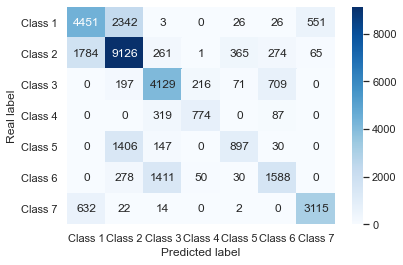

In [129]:
y_pred = cvp(model_2, X_train_under_over, y_under_over, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_under_over, labels=labels_multi)
# Plotting confusion matrix (custom help function)
plot_confusion_matrix(cm, [class_labels_multi]) 

In [130]:
####  Classification report
print (classification_report(y_under_over, y_pred))

              precision    recall  f1-score   support

           1       0.65      0.60      0.62      7399
           2       0.68      0.77      0.72     11876
           3       0.66      0.78      0.71      5322
           4       0.74      0.66      0.70      1180
           5       0.64      0.36      0.46      2480
           6       0.59      0.47      0.52      3357
           7       0.83      0.82      0.83      3785

    accuracy                           0.68     35399
   macro avg       0.69      0.64      0.65     35399
weighted avg       0.68      0.68      0.67     35399



### Balancing method 3: SMOTE

Class=1, n=22199 (36.388%)
Class=2, n=29690 (48.667%)
Class=3, n=3802 (6.232%)
Class=4, n=295 (0.484%)
Class=7, n=2163 (3.546%)
Class=6, n=1865 (3.057%)
Class=5, n=992 (1.626%)


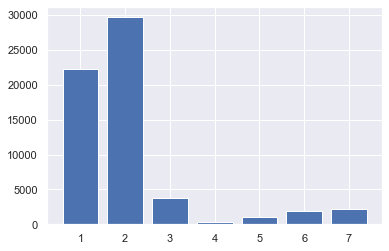

In [131]:
# we check the percentage share of each class
counter = Counter(y_multi)
for k,v in counter.items():
	per = v / len(y_multi) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [133]:
# transform the dataset
oversample = SMOTE()
X_sm_multi, y_sm_multi = oversample.fit_resample(X_train_multi, y_multi)


# summarize the new class distribution
counter = Counter(y_sm_multi)
print(counter)

Counter({1: 29690, 2: 29690, 3: 29690, 4: 29690, 7: 29690, 6: 29690, 5: 29690})


In [136]:
# define model
model = LogisticRegression(warm_start=True, multi_class='multinomial')
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 15)
# define search
search = RandomizedSearchCV(model, space, n_iter=3, scoring='accuracy', n_jobs=3, cv=cv, random_state=1, verbose=25)
# execute search
result = search.fit(X_sm_multi, y_sm_multi)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score: 0.7140210749169995
Best Hyperparameters: {'C': 0.2810540239567601, 'penalty': 'l2', 'solver': 'newton-cg'}


In [139]:
#We fit a model based on this from this SMOTE dataset and hyperparameter optimization
model_sm = LogisticRegression(C=0.2810540239567601,multi_class="multinomial",solver="newton-cg",max_iter=10000, intercept_scaling=1)

model_sm.fit(X_sm_multi, y_sm_multi)

LogisticRegression(C=0.2810540239567601, max_iter=10000,
                   multi_class='multinomial', solver='newton-cg')

### Step 5: Assess expected accuracy

In [141]:
# AUC
cvs(model_sm, X_sm_multi, y_sm_multi, cv = 3, scoring='roc_auc_ovr').mean()

0.9531363570805302

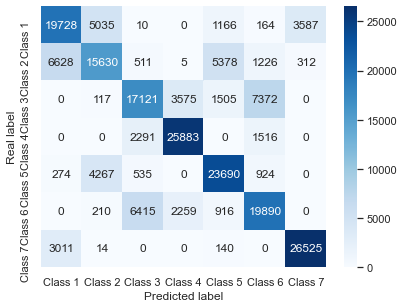

In [148]:
y_pred = cvp(model_sm, X_sm_multi, y_sm_multi, cv = 3)
cm =  confusion_matrix(y_pred=y_pred, y_true=y_sm_multi, labels=labels_multi)
# Plotting confusion matrix 

my_plot_size_default()
plot_confusion_matrix(cm, class_labels_multi) 

#we observe from our SMOTE dataset, the model that we fit was better in predicting the minority classes from before
# on the other hand, the predictions for classes 2 and 1 (the major classes) became relatively worse

In [144]:
####  Classification report
print (classification_report(y_sm_multi, y_pred))

#since we have used a balanced dataset, the classfication table shows higher accuracy/f1-score for the types that have been in the minority before

              precision    recall  f1-score   support

           1       0.67      0.66      0.67     29690
           2       0.62      0.53      0.57     29690
           3       0.64      0.58      0.61     29690
           4       0.82      0.87      0.84     29690
           5       0.72      0.80      0.76     29690
           6       0.64      0.67      0.65     29690
           7       0.87      0.89      0.88     29690

    accuracy                           0.71    207830
   macro avg       0.71      0.71      0.71    207830
weighted avg       0.71      0.71      0.71    207830



In [146]:
y_pred = model_sm.predict(X_test)

### Balancing method 4: RandomUnderSampler

In [260]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_multi, y_multi)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 295, 2: 295, 3: 295, 4: 295, 5: 295, 6: 295, 7: 295})


In [261]:
model_d = LogisticRegression(max_iter=500, C = 10.47600364305654, penalty = 'l2', solver = 'newton-cg')

model_d.fit(X_res, y_res)

LogisticRegression(C=10.47600364305654, max_iter=500, solver='newton-cg')

### Step 5: Assess expected accuracy

In [ ]:
# AUC
cvs(model_d, final_X_train_multi, y_multi, cv = 5, scoring='roc_auc_ovr').mean()

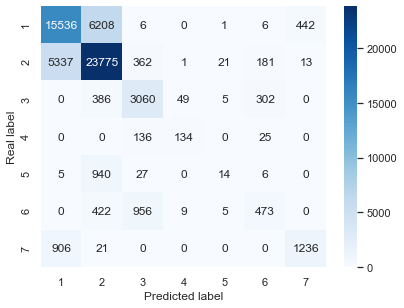

In [274]:
y_pred = cvp(model_d, X_train_multi, y_multi, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_multi, labels=[1,2,3,4,5,6,7])
# Plotting confusion matrix (custom help function)
plot_confusion_matrix(cm, ["1","2","3","4","5","6","7"]) 

In [275]:
####  Classification report
print (classification_report(y_multi, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.70      0.71     22199
           2       0.75      0.80      0.77     29690
           3       0.67      0.80      0.73      3802
           4       0.69      0.45      0.55       295
           5       0.30      0.01      0.03       992
           6       0.48      0.25      0.33      1865
           7       0.73      0.57      0.64      2163

    accuracy                           0.72     61006
   macro avg       0.62      0.51      0.54     61006
weighted avg       0.71      0.72      0.72     61006



Note that when we did SMOTE, our balanced dataset had around 210000 observatoions. This gargantuan dataset has been created since we resample the minority class to have the same number of observations as the majority class. 

For RandomUnderSampler, we have also equalized all the number of observations per type/class, following the type/class with the fewest number of observations. This is not good since we are throwing away information. 

From these insights/observations, the optimal way to tackle class imbalance for this specific dataset is to do both oversampling (either via SMOTE or just randomly taking samples from the minority class with replacement) and undersampling of the majority classes. This would be similar to what we did in balancing method 2 where we both used oversampling and undersamping. It depends on whether you would like for all the classes to have same number of observations. As for me, I wanted to preserve the heirarchy in terms of number of observations, while still making the dataset more balanced.

### Step 9: Produce .csv for kaggle testing 

In [276]:
#on test data

In [278]:
#on external / never before seen data

#now we use the test dataset to export results to Kaggle
test = test_orig

In [279]:
X_test.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.545709,-0.750909,-0.152141,0.066669,0.503118,-1.102917,0.854629,-0.460602,-0.876299,-1.124175,...,4.656051,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
1,-0.675142,-1.392540,0.776076,-0.636026,-0.353048,-0.922167,-0.958176,-1.264233,0.087632,-0.004190,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
2,1.431982,1.031401,-0.152141,1.962530,2.249696,1.378873,-0.995172,1.046206,1.442346,0.503030,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,6.348543,-0.121675
3,-1.938704,-1.392540,-1.478165,-0.320049,-0.490034,-1.147784,0.114709,0.493709,0.348154,-0.845508,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
4,-0.507853,-0.911317,-0.417346,-1.069904,-0.644144,-0.024184,0.521665,-0.309922,-0.511569,0.673116,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675


In [280]:
y_pred = model_d.predict(X_test)

In [281]:
y_proba = model_d.predict_proba(X_test)

In [147]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": test_orig["Index"], "Cover_Type": y_pred})
test_predictions_submit.to_csv("test_LogReg_predictions_submit.csv", index = False)

# Transformed Datasets (with Polynomial Features)

Previously, I only used dummies since my lack of domain knowledge lead me to believe that there are not interactions between featuresand that there are no quadaratic relationship between features and class type. But still, it might be worthwhile to explore the dataset will polynomial features. So we will do this, we just have to add a lot more steps.

## Creating binary model based on a transformed dataset

*Balanced by using SMOTE, adapting the tuned parameters of the binary model from the original dataset*

We separate features on which we will do dummies and do polynomial features on.

In [98]:
potential = ['Wilderness_Area', 'Soil_Type']

for i in potential:
    print(len(pd.unique(train[i])))

for i in potential:
    print(len(pd.unique(test[i])))

4
39
4
39


Since the number of dummies is that many, for binary, we do not have to be so strict in the number of dummies since it's faster to train.

In [99]:
X_train_d = train[['Wilderness_Area', 'Soil_Type']]
X_train_d_bi = pd.get_dummies(X_train_d, columns=['Wilderness_Area', 'Soil_Type'],drop_first=True)
X_train_d_columns_bi = X_train_d_bi.columns

Now transforming using polynomial features

In [100]:
X_train_f = train.drop(['Wilderness_Area', 'Soil_Type', 'Cover_Type'], axis=1)

poly = plf(2)
X_train_f_bi = poly.fit_transform(X_train_f)
X_train_f_columns_bi = np.array(poly.get_feature_names(X_train_f.columns))
X_train_columns_bi = np.concatenate([X_train_f_columns_bi, X_train_d_columns_bi])
final_X_train_bi = np.concatenate((X_train_bi, X_train_d_bi), axis=1)
final_X_train_bi = np.concatenate((X_train_f_bi, X_train_d_bi), axis=1)
final_X_train_bi = pd.DataFrame(final_X_train_bi)
final_X_train_bi.columns = X_train_columns_bi
final_X_train_bi = final_X_train_bi.drop(['1'],axis=1)
final_X_train_bi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,3202.0,34.0,10.0,0.0,0.0,2760.0,219.0,218.0,134.0,1734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3113.0,251.0,13.0,192.0,40.0,5600.0,191.0,249.0,195.0,2555.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2801.0,77.0,9.0,510.0,17.0,1728.0,232.0,223.0,122.0,1087.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3165.0,82.0,9.0,319.0,56.0,4890.0,233.0,225.0,124.0,1452.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3048.0,333.0,11.0,124.0,31.0,2823.0,196.0,226.0,170.0,666.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
final_X_test_bi = my_total_transformer_bi(test)

In [102]:
final_X_test_bi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,3111.0,72.0,13.0,283.0,76.0,630.0,235.0,214.0,109.0,499.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2768.0,0.0,20.0,134.0,26.0,912.0,186.0,198.0,146.0,1974.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3360.0,272.0,13.0,685.0,178.0,4502.0,185.0,244.0,198.0,2642.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2413.0,0.0,3.0,201.0,18.0,560.0,215.0,233.0,156.0,866.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2815.0,54.0,11.0,42.0,9.0,2313.0,226.0,217.0,123.0,2866.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
#scaling
final_X_train_bi, final_X_test_bi = my_scaler(final_X_train_bi, final_X_test_bi)

In [104]:
final_X_train_bi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.869608,-1.089548,-0.549948,-1.267979,-0.798254,0.262324,0.262693,-0.259695,-0.224995,-0.186425,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,6.048836,-0.157516,-0.121675
1,0.552827,0.844259,-0.152141,-0.362494,-0.113321,2.082645,-0.773196,1.297340,1.364189,0.436970,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
2,-0.557684,-0.706351,-0.682551,1.137217,-0.507158,-0.399145,0.743641,-0.008560,-0.537621,-0.677700,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
3,0.737912,-0.661793,-0.682551,0.236447,0.160652,1.627565,0.780637,0.091894,-0.485516,-0.400551,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675
4,0.321471,1.575006,-0.417346,-0.683187,-0.267431,0.302704,-0.588216,0.142121,0.712884,-0.997370,...,-0.214774,-0.313303,-0.290545,-0.054399,-0.056918,-0.012804,-0.021042,-0.165321,-0.157516,-0.121675


In [60]:
final_X_test_bi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40
0,0.542354,-0.755712,-0.155142,0.078855,0.505860,-1.106881,0.852761,-0.468094,-0.872820,-1.111472,...,4.776231,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441
1,-0.687794,-1.396990,0.777410,-0.629645,-0.341629,-0.925999,-0.960632,-1.278194,0.086613,-0.014140,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441
2,1.435377,1.025613,-0.155142,1.990379,2.234739,1.376711,-0.997640,1.050843,1.435005,0.482821,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,6.405886,-0.114441
3,-1.960980,-1.396990,-1.487359,-0.311058,-0.477227,-1.151780,0.112601,0.493900,0.345919,-0.838441,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441
4,-0.519232,-0.916032,-0.421585,-1.067108,-0.629775,-0.027365,0.519689,-0.316200,-0.509792,0.649467,...,-0.209370,-0.320243,-0.297048,-0.051812,-0.045493,-0.017495,-0.026247,-0.169476,-0.156106,-0.114441


In [174]:
# define model
lregr_balanced_tr = LogisticRegression(max_iter=1000, class_weight='balanced')
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['liblinear']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 12)
# define search
search = RandomizedSearchCV(lregr_balanced_tr, space, n_iter=20, scoring='accuracy', n_jobs=3, cv=cv, random_state=1, verbose=20)
# execute search
result = search.fit(final_X_train_bi, y_bi)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Best Score: 0.9352194707757591
Best Hyperparameters: {'C': 2.1788887228577316, 'penalty': 'l2', 'solver': 'liblinear'}


In [182]:
#we use the parameter we got from the hyperparameter optimization of the unbalanced data
lregr_balanced_tr = LogisticRegression(penalty='l2', C=2.1788887228577316, solver='liblinear', intercept_scaling=1, max_iter=1000, class_weight='balanced',verbose=100)
lregr_balanced_tr.fit(final_X_train_bi,y_bi)

[LibLinear]

LogisticRegression(C=2.1788887228577316, class_weight='balanced', max_iter=1000,
                   solver='liblinear', verbose=100)

In [183]:
#in-sample
labels_balanced = lregr_balanced_tr.predict(final_X_train_bi)
print(labels_balanced)

[1 0 0 ... 0 0 0]


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][[55000  3843]
 [  104  2059]]


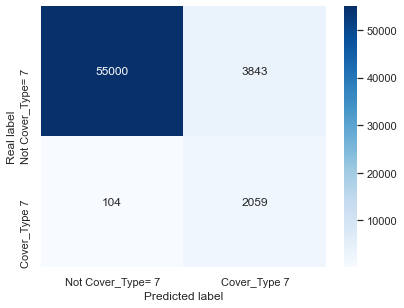

In [184]:
#confusion matrix
y_pred = cvp(lregr_balanced_tr, final_X_train_bi,y_bi, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_bi, labels=[0,1])
print (cm)
# Plotting confusion matrix (custom help function)

plot_confusion_matrix(cm, ["Not Cover_Type= 7", "Cover_Type 7"])

#now, with the balanced model, we make more errors but we identify the smaller class (Class 7) more correctly than in the previous unbalanced model

In [185]:
y_prob_balanced = lregr_balanced_tr.predict_proba(final_X_train_bi) 
#note that these probabilities are not correct, so we need to reweight

In [186]:
#applying the reqeight correction factor from before
q1 = y_bi.sum()/len(y_bi)
r1 = 0.5

# for train
reweighted_probs = pd.Series(lregr_balanced_tr.predict_proba(final_X_train_bi)[:,1]).apply(reweight,args=(q1,r1))

In [187]:
reweighted_probs[-10:]

60996    2.311065e-09
60997    9.019126e-05
60998    1.099102e-03
60999    1.038532e-04
61000    4.573535e-04
61001    3.819341e-01
61002    5.284057e-04
61003    3.645250e-05
61004    1.009988e-07
61005    2.734891e-08
dtype: float64

In [190]:
#for test

reweighted_probs = pd.Series(lregr_balanced_tr.predict_proba(final_X_test_bi)[:,1]).apply(reweight,args=(q1,r1))

In [ ]:
#cross validation
y_hat_cv_balanced = cvp(lregr_balanced_tr, final_X_train_bi, y_bi, cv=5)

In [ ]:
cm =  confusion_matrix(y_pred=y_hat_cv_balanced, y_true=y_bi, labels=[0,1])
print (cm)
# Plotting confusion matrix 
plot_confusion_matrix(cm, ["Not Cover_Type= 7", "Cover_Type 7"])

#using cross-validated data, the performance of our balanced model (lregr with class_weight='balanced') 
#is still similar to when we used in-sample data

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]AUC:  0.9772734452820298


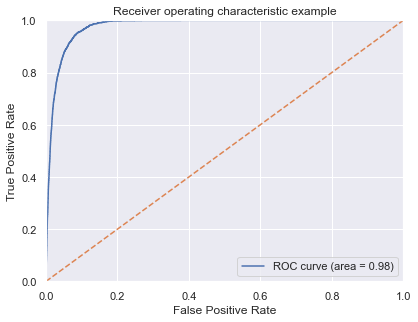

Accuracy (cross-validated):  0.9133363931416582
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     58843
           1       0.28      0.95      0.44      2163

    accuracy                           0.91     61006
   macro avg       0.64      0.93      0.70     61006
weighted avg       0.97      0.91      0.93     61006



In [71]:
#repeating for reweigted
#Step 5: Assess expected accuracy: AUC
# AUC
y_probabilities = cvp(lregr_balanced_tr, final_X_train_bi, y_bi, method='predict_proba', cv = 5)
get_auc(y_bi, y_probabilities, ["Not Class 7", "Class 7"], column=1, plot=True) 

#### Accuracy

print ("Accuracy (cross-validated): ", accuracy_score(y_bi, y_hat_cv_balanced))
#accuracy score of the model using cross-validated data is 92%

print (classification_report(y_bi, y_hat_cv_balanced))

In [113]:
# Step 6: Report variable impact
lregr_balanced_tr.coef_

array([[ 5.87775653e+00, -1.66674402e-01, -2.14438571e-01,
        -5.14230366e-01,  5.43478128e-02, -3.60693975e-01,
        -1.39205698e+00,  1.06715369e+00, -2.02365845e+00,
         5.01424344e-01, -2.53757460e-01,  9.31868406e-01,
        -5.46413768e-02, -8.67167075e-02, -4.03127839e-02,
         1.01034086e+00, -4.71146762e-05, -4.55585662e-04,
        -4.36317793e-02, -6.25392838e-02, -2.65060239e-03,
        -4.91160270e-01, -4.02014019e-01, -7.35101252e-01,
        -5.80155596e-03, -1.43802508e-04, -3.53451769e-01,
        -2.12866365e-01, -1.99435191e-01,  2.91206270e-02,
        -6.57672415e-01, -4.73358782e-02, -1.38638905e-01,
         2.61236902e-01,  5.21693148e-02, -2.64656558e-01,
        -3.56419847e-01, -4.22386863e-03, -1.79335754e-01,
         7.03425845e-01,  4.56358479e-01, -1.69847499e-01,
        -3.02111398e-01, -3.36345159e-01,  5.84070932e-02,
         9.41272559e-02,  8.88369309e-03,  2.27612146e-01,
         4.27292742e-01,  3.19344054e-01,  1.72974056e-0

In [64]:
#I've tried to use Epsilon-Support Vector Regression but I am not that familiar with it.
#I've read that this is a popular machine learning tool for classification and regression.
# I've considered using this as I wondered how my classmates are getting more than 99% and 80% accuracy 
# for biniary and multinomial classfication respectiely


from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
svm = LinearSVC(max_iter=3000)
clf = CalibratedClassifierCV(svm) 
clf.fit(final_X_train_bi, y_bi)
y_proba = clf.predict_proba(X_test)
# weirdly, the probabilities that this returns are very small

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

In [65]:
print(y_proba)

[[9.93949299e-01 6.05070055e-03]
 [9.99105470e-01 8.94530449e-04]
 [3.53122934e-01 6.46877066e-01]
 ...
 [9.99215811e-01 7.84188860e-04]
 [9.99936479e-01 6.35210011e-05]
 [9.25456961e-01 7.45430395e-02]]


## Creating multinomial model based on a transformed dataset

Balanced by using random_undersampler, adapting the tuned parameters from the original dataset

Dummy Variable Generation

Let's check first the number of unique variables that we plan to have dummies on.

In [65]:
potential = ['Wilderness_Area', 'Soil_Type']

for i in potential:
    print(len(pd.unique(train[i])))

for i in potential:
    print(len(pd.unique(test[i])))

4
39
4
39


We observe that there are too many unique values for Soil_Type for both the train and test datasets We will also create dummy for it but we will impose additional constraints on which values we are making dummies on. I only want to create dummies for Soil_Types that occurs frequently in our dataset. Hence, I will use a cut-off.

Later on, it is also important to make sure that the dummies in the train dataset will be the same as in the test dataset.

In [66]:
X_train_multi_tr = train.copy()

In [67]:
X_train_multi_tr.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,3202,34,10,0,0,2760,219,218,134,1734,1,3,38
1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,3048,333,11,124,31,2823,196,226,170,666,1,1,23


In [68]:
soil_stats = X_train_multi_tr['Soil_Type'].value_counts(ascending=False) #we count the number of unique values, sort them from highest to lowest, store the results to soil_stats
soil_stats

29    12123
23     6026
32     5453
33     4749
22     3523
10     3483
12     3220
30     3141
31     2690
24     2249
13     1831
38     1623
39     1477
4      1299
11     1276
20      926
40      890
2       802
6       695
3       507
19      418
17      349
1       346
16      309
26      279
18      197
35      197
34      180
5       172
27      109
28      107
9       104
21       72
14       65
25       49
37       27
8        21
7        12
36       10
Name: Soil_Type, dtype: int64

In [69]:
soil_stats.values.sum() #checking if it would sum to total number of obs, and it is

61006

In [70]:
len(soil_stats[soil_stats>2000]) #counting neighborhoodcodes with more than 2000 obs
#I've decided that I am okay with have 10+1-1 dummies (soil types with more than 2000 obs + others - drop_first)

10

In [71]:
len(soil_stats[soil_stats<=2000]) #there are 29 neighborhoods with less than 100 obs
#all of these soil types will be identified as others later

29

In [72]:
soil_stats_less_than_2000 = soil_stats[soil_stats<=2000] #we store the neighborhoods will less than 100 obs
soil_stats_less_than_2000

13    1831
38    1623
39    1477
4     1299
11    1276
20     926
40     890
2      802
6      695
3      507
19     418
17     349
1      346
16     309
26     279
18     197
35     197
34     180
5      172
27     109
28     107
9      104
21      72
14      65
25      49
37      27
8       21
7       12
36      10
Name: Soil_Type, dtype: int64

In [73]:
soil_stats_less_than_2000.shape #contains one column of the number of obs of neighborhoods with less than 100 obs

(29,)

In [74]:
X_train_multi_tr.Soil_Type = X_train_multi_tr.Soil_Type.apply(lambda x: 'other' if x in soil_stats_less_than_2000 else x) #we are replacing the values with 'other' for those soil types with less than 100 obs
len(X_train_multi_tr.Soil_Type.unique()) #now, we only have 11 unique neighborhoodcodes instead of 39

11

In [75]:
X_train_multi_tr.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Cover_Type,Wilderness_Area,Soil_Type
0,3202,34,10,0,0,2760,219,218,134,1734,1,3,other
1,3113,251,13,192,40,5600,191,249,195,2555,2,1,22
2,2801,77,9,510,17,1728,232,223,122,1087,2,1,12
3,3165,82,9,319,56,4890,233,225,124,1452,1,1,29
4,3048,333,11,124,31,2823,196,226,170,666,1,1,23


In [76]:
X_train_multi_tr.Soil_Type.unique()

array(['other', 22, 12, 29, 23, 10, 33, 31, 32, 24, 30], dtype=object)

We do the same encoding for the test dataset.

Note that we only do the last step because we want the test dataset to have the same dummies as the train dataset.

In [77]:
X_test_multi_tr = test.copy()

In [78]:
X_test_multi_tr.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,Wilderness_Area,Soil_Type
0,3111,72,13,283,76,630,235,214,109,499,3,31
1,2768,0,20,134,26,912,186,198,146,1974,3,10
2,3360,272,13,685,178,4502,185,244,198,2642,3,39
3,2413,0,3,201,18,560,215,233,156,866,3,2
4,2815,54,11,42,9,2313,226,217,123,2866,1,29


In [79]:
X_test_multi_tr.Soil_Type = X_test_multi_tr.Soil_Type.apply(lambda x: 'other' if x in soil_stats_less_than_2000 else x)
len(X_test_multi_tr.Soil_Type.unique())

11

Now we finally generate the dummies. Note that I will be dropping the first columns using drop_first=True to avoid the dummy variable trap.

In [80]:
X_train_d_multi = X_train_multi_tr[potential]
X_train_d_multi = pd.get_dummies(X_train_d_multi, columns=potential,drop_first=True)
X_train_d_columns_multi = X_train_d_multi.columns

Next we try the transform our dataframe with polynomial features. Since I have no domain knowledge, I will not preselect the columns that I will transform using polynomial features. The model fitting might be longer, but that's okay.

In [83]:
poly = plf(2)

X_train_f_multi = train.drop(['Wilderness_Area', 'Soil_Type', 'Cover_Type'], axis=1) 
X_train_f_multi_1 = poly.fit_transform(X_train_f_multi) #transforming to poly features
X_train_f_columns_multi = np.array(poly.get_feature_names(X_train_f_multi.columns)) #storing poly features
X_train_columns_multi = np.concatenate([X_train_f_columns_multi, X_train_d_columns_multi]) #concatenating column names
final_X_train_multi = np.concatenate((X_train_f_multi_1, X_train_d_multi), axis=1) #concatenating dataframes that contain polynomial tranformations and dummies
final_X_train_multi = pd.DataFrame(final_X_train_multi)
final_X_train_multi.columns = X_train_columns_multi
final_X_train_multi = final_X_train_multi.drop(['1'],axis=1)
final_X_train_multi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_12,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_other
0,3202.0,34.0,10.0,0.0,0.0,2760.0,219.0,218.0,134.0,1734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3113.0,251.0,13.0,192.0,40.0,5600.0,191.0,249.0,195.0,2555.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2801.0,77.0,9.0,510.0,17.0,1728.0,232.0,223.0,122.0,1087.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3165.0,82.0,9.0,319.0,56.0,4890.0,233.0,225.0,124.0,1452.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3048.0,333.0,11.0,124.0,31.0,2823.0,196.0,226.0,170.0,666.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
# we do the same for the test set
X_test_d_multi = X_test_multi_tr[potential]
X_test_d_multi = pd.get_dummies(X_test_d_multi, columns=potential,drop_first=True)
X_test_d_columns_multi = X_test_d_multi.columns

X_test_f_multi = test.drop(['Wilderness_Area', 'Soil_Type'], axis=1)
X_test_f_multi_1 = poly.fit_transform(X_test_f_multi)
X_test_f_columns_multi = np.array(poly.get_feature_names(X_test_f_multi.columns))
X_test_columns_multi = np.concatenate([X_test_f_columns_multi, X_test_d_columns_multi])
final_X_test_multi = np.concatenate((X_test_f_multi_1, X_test_d_multi), axis=1)
final_X_test_multi = pd.DataFrame(final_X_test_multi)
final_X_test_multi.columns = X_test_columns_multi
final_X_test_multi = final_X_test_multi.drop(['1'],axis=1)
final_X_test_multi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_12,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_other
0,3111.0,72.0,13.0,283.0,76.0,630.0,235.0,214.0,109.0,499.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2768.0,0.0,20.0,134.0,26.0,912.0,186.0,198.0,146.0,1974.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3360.0,272.0,13.0,685.0,178.0,4502.0,185.0,244.0,198.0,2642.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2413.0,0.0,3.0,201.0,18.0,560.0,215.0,233.0,156.0,866.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2815.0,54.0,11.0,42.0,9.0,2313.0,226.0,217.0,123.0,2866.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [85]:
#scaling
final_X_train_multi, final_X_test_multi = my_scaler(final_X_train_multi, final_X_test_multi)

In [86]:
final_X_train_multi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_12,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_other
0,0.869608,-1.089548,-0.549948,-1.267979,-0.798254,0.262324,0.262693,-0.259695,-0.224995,-0.186425,...,-0.236057,-0.247563,-0.331064,-0.195643,-0.497996,-0.232984,-0.214774,-0.313303,-0.290545,1.803215
1,0.552827,0.844259,-0.152141,-0.362494,-0.113321,2.082645,-0.773196,1.297340,1.364189,0.436970,...,-0.236057,4.039368,-0.331064,-0.195643,-0.497996,-0.232984,-0.214774,-0.313303,-0.290545,-0.554565
2,-0.557684,-0.706351,-0.682551,1.137217,-0.507158,-0.399145,0.743641,-0.008560,-0.537621,-0.677700,...,4.236268,-0.247563,-0.331064,-0.195643,-0.497996,-0.232984,-0.214774,-0.313303,-0.290545,-0.554565
3,0.737912,-0.661793,-0.682551,0.236447,0.160652,1.627565,0.780637,0.091894,-0.485516,-0.400551,...,-0.236057,-0.247563,-0.331064,-0.195643,2.008047,-0.232984,-0.214774,-0.313303,-0.290545,-0.554565
4,0.321471,1.575006,-0.417346,-0.683187,-0.267431,0.302704,-0.588216,0.142121,0.712884,-0.997370,...,-0.236057,-0.247563,3.020562,-0.195643,-0.497996,-0.232984,-0.214774,-0.313303,-0.290545,-0.554565


In [87]:
final_X_test_multi.head()

,Elevation,Aspect,Slope,Horiz_dist_hydro,Vertical_dist_hydro,Horiz_dist_roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horiz_dist_firepoints,...,Soil_Type_12,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_other
0,0.542354,-0.755712,-0.155142,0.078855,0.505860,-1.106881,0.852761,-0.468094,-0.872820,-1.111472,...,-0.243017,-0.249135,-0.33045,-0.194176,-0.499091,-0.230218,4.776231,-0.320243,-0.297048,-0.548095
1,-0.687794,-1.396990,0.777410,-0.629645,-0.341629,-0.925999,-0.960632,-1.278194,0.086613,-0.014140,...,-0.243017,-0.249135,-0.33045,-0.194176,-0.499091,-0.230218,-0.209370,-0.320243,-0.297048,-0.548095
2,1.435377,1.025613,-0.155142,1.990379,2.234739,1.376711,-0.997640,1.050843,1.435005,0.482821,...,-0.243017,-0.249135,-0.33045,-0.194176,-0.499091,-0.230218,-0.209370,-0.320243,-0.297048,1.824502
3,-1.960980,-1.396990,-1.487359,-0.311058,-0.477227,-1.151780,0.112601,0.493900,0.345919,-0.838441,...,-0.243017,-0.249135,-0.33045,-0.194176,-0.499091,-0.230218,-0.209370,-0.320243,-0.297048,1.824502
4,-0.519232,-0.916032,-0.421585,-1.067108,-0.629775,-0.027365,0.519689,-0.316200,-0.509792,0.649467,...,-0.243017,-0.249135,-0.33045,-0.194176,2.003641,-0.230218,-0.209370,-0.320243,-0.297048,-0.548095


In [ ]:
# define model
model_tr = LogisticRegression(max_iter=1000, class_weight='balanced')
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 12)
# define search
search = RandomizedSearchCV(model_tr, space, n_iter=15, scoring='accuracy', n_jobs=3, cv=cv, random_state=1,verbose=10)
# execute search
result = search.fit(final_X_train_multi, y_multi)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [258]:
model_balanced_tr = LogisticRegression(C=2.1788887228577316,multi_class="multinomial",solver="newton-cg",max_iter=1000, intercept_scaling=1, class_weight='balanced')
model_balanced_tr.fit(final_X_train_multi, y_multi)

LogisticRegression(C=2.1788887228577316, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', solver='newton-cg')

In [259]:
#save model using joblib
filename = 'model_balanced_tr.sav'
joblib.dump(model_balanced_tr, filename)

['model_balanced_tr.sav']

In [260]:
# load the model from disk
joblib_model_balanced = joblib.load(filename)

### Step 5: Assess expected accuracy

In [262]:
# AUC
cvs(model_balanced_tr, final_X_train_multi, y_multi, cv = 5, scoring='roc_auc_ovr').mean()
#note that the AUC did not improve much compared to the dataset that we did not do polynomial features on

0.9316438786528929

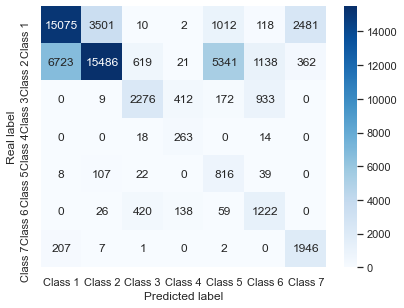

In [263]:
#For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes
#(check metrics.confusion_matrix and metrics.classification_report in sklearn)

y_pred = cvp(model_balanced_tr, final_X_train_multi, y_multi, cv = 5) ## by default this gives labels
cm =  confusion_matrix(y_pred=y_pred, y_true=y_multi, labels=labels_multi)
# Plotting confusion matrix (custom help function)
plot_confusion_matrix(cm, class_labels_multi) 

In [264]:
####  Classification report
print (classification_report(y_multi, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.68      0.68     22199
           2       0.81      0.52      0.63     29690
           3       0.68      0.60      0.64      3802
           4       0.31      0.89      0.47       295
           5       0.11      0.82      0.19       992
           6       0.35      0.66      0.46      1865
           7       0.41      0.90      0.56      2163

    accuracy                           0.61     61006
   macro avg       0.48      0.72      0.52     61006
weighted avg       0.71      0.61      0.64     61006



**We notice that the overall performance of our model declined. i hypothesize that this is from lumping the soil_types that had less than 2000 observations. looking back, such strict conditions (more than 2000 obs) will really weaken our model since some classes/cover_types have less than 2000 observations. 
it is very likely that the soil_types that are usual for the minor cover type have been dropped due to this strict condition**

If I were to recreate this model transformations, I will still do polynomial transformations of order 2 and include all the dummies of the soil types, even if this means that I will have 150+ columns. I could just remove them later on throug various method such as SVD, variance treshold, Recursive Feature Elimination, etc.

Also, I've learned that feature engineering, especially for this case is more important than hyperparameter tuning. Next time, I will do my hyperparameter tuning on the dataset will polynomial features and complete dummies, even if this means that the gridsearch will take longer. I could just always used randomizedgridsearch and reduce n_iter.

In [265]:
# Step 6: Report variable impact
print(model_balanced_tr.coef_)

[[-3.88144218e+00  2.26073191e-01 -8.54531518e-01  6.08193292e-01
  -3.48580498e+00 -8.99497001e-01  7.70272976e-01 -3.91486433e-01
  -5.13553000e-01 -1.66147198e+00  7.08688709e+00 -4.42284882e-01
   2.65948890e+00  3.66383430e+00  3.34347543e+00  1.93293830e+00
  -4.24618150e-01  1.83716996e+00 -2.78892714e-01  8.00887383e-02
   1.60562019e+00 -4.37425844e-01 -3.98120676e-01  2.79563895e-01
   7.38794499e-02 -1.13481870e+00  2.47784409e-01  2.57698694e-01
  -4.22870311e-01  1.10222153e-01 -7.57912331e-01  3.53819161e-01
  -3.04235630e-01 -1.81797728e+00  2.51103959e-01 -2.01291202e-01
   3.92384322e-01 -5.57120546e-01  2.03797896e-01 -5.08419835e-01
  -1.24393019e+00 -1.16604025e+00 -7.39586018e-01  1.78715227e-01
   1.30532533e-01 -4.22275735e-01 -2.40940908e+00  3.08567548e+00
  -1.62379529e+00 -2.12648465e-02  2.45082376e+00  5.43298901e-01
  -1.79838044e-01 -1.42090803e+00 -1.27663991e+00  6.99366941e-01
  -1.47189145e+00  4.90731932e-01  1.05783941e-01 -2.79583823e-01
   8.48761

*Other classifcation models*

In [90]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=0, verbose=1).fit(final_X_train_multi, y_multi)
clf.score(final_X_train_multi, y_multi)

      Iter       Train Loss   Remaining Time 
         1           1.3740            3.70m
         2          48.0256            3.69m
         3 1145958415784000090902615989824359247288188521397239912746112034711614460796407877082432309895201155894358165972423016448.0000            3.66m
         4 1145958415784000090902615989824359247288188521397239912746112034711614460796407877082432309895201155894358165972423016448.0000            3.63m
         5 1145958415784000090902615989824359247288188521397239912746112034711614460796407877082432309895201155894358165972423016448.0000            3.58m
         6 1145958415784000090902615989824359247288188521397239912746112034711614460796407877082432309895201155894358165972423016448.0000            3.55m
         7 1145958415784000090902615989824359247288188521397239912746112034711614460796407877082432309895201155894358165972423016448.0000            3.51m
         8 114595841578400009090261598982435924728818852139723991274611203471161446079640

0.6291676228567682

In [107]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,
max_depth=1, random_state=0, verbose=1).fit(final_X_train_bi, y_bi)
clf.score(final_X_train_bi, y_bi)

      Iter       Train Loss   Remaining Time 
         1           0.6685            2.85m
         2          42.2234            2.79m
         3          42.2233            2.88m
         4          42.2233            2.89m
         5          42.2233            2.88m
         6          42.2233            2.98m
         7          42.2233            3.08m
         8          42.2233            3.05m
         9          42.2233            3.06m
        10          42.2233            3.07m
        20          42.2233            2.93m
        30          42.2233            2.78m
        40          42.2233            2.71m
        50          42.2233            2.66m
        60          42.2233            2.61m
        70          42.2233            2.56m
        80          42.2233            2.50m
        90          42.2233            2.44m
       100          42.2233            2.39m
       200          42.2233            1.79m
       300          42.2233            1.21m
       40

0.9645444710356358

In [114]:
y_pred = clf.predict(final_X_test_bi)

In [115]:
print(y_pred)

[0 0 0 ... 0 0 0]


In [ ]:
#Recursive Feature Elimination

data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "Index"'s and the other with your probability of the "Covert_Type" being class 7

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [116]:
# Step 9: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": test_orig["Index"], "Cover_Type": y_pred})
test_predictions_submit.to_csv("test_LogReg_predictions_submit.csv", index = False)